In [42]:
import pandas as pd
import glob
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import metapredict as meta
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings('ignore')
sns.set_context('talk')

In [113]:
glob.glob("../soto_analysis/outputs/AD_variant_fasta/*")

['../soto_analysis/outputs/AD_variant_fasta/GLIS1_Q8NBF1_AD_447-620',
 '../soto_analysis/outputs/AD_variant_fasta/RORA_P35398_AD_272-385',
 '../soto_analysis/outputs/AD_variant_fasta/VDR_P11473_AD_415-427',
 '../soto_analysis/outputs/AD_variant_fasta/SRCAP_Q6ZRS2_AD_2575-3230',
 '../soto_analysis/outputs/AD_variant_fasta/THRA_P10827_AD_1-52',
 '../soto_analysis/outputs/AD_variant_fasta/YY1_P25490_AD_371-397',
 '../soto_analysis/outputs/AD_variant_fasta/NCOA1_Q15788_AD_840-1011',
 '../soto_analysis/outputs/AD_variant_fasta/SRCAP_Q6ZRS2_AD_198-1445',
 '../soto_analysis/outputs/AD_variant_fasta/ERG_P11308_AD_118-261',
 '../soto_analysis/outputs/AD_variant_fasta/CAMTA2_O94983_AD_472-581',
 '../soto_analysis/outputs/AD_variant_fasta/ERG_P11308_AD_433-479',
 '../soto_analysis/outputs/AD_variant_fasta/EBF3_Q9H4W6_AD_281-360',
 '../soto_analysis/outputs/AD_variant_fasta/MSX2_P35548_AD_234-267',
 '../soto_analysis/outputs/AD_variant_fasta/YY1_P25490_AD_1-69',
 '../soto_analysis/outputs/AD_varia

In [43]:
cc_names = pd.read_excel("../data/gene_names_with_location_and_pmvs.xlsx")
cc_names = cc_names.rename(columns = {"gene" : "Gene", "start" : "Start", "end" : "End"})
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms_and_canonical.csv")
cc_names = pd.merge(known_ADs[["uniprotID", "Gene", "Start", "End"]], cc_names)
ensts = pd.read_csv("../data/SFARI_TFs_with_ENST_corrected.csv", index_col = 0)
cc_names = pd.merge(cc_names, ensts)
cc_names["ENST"] = cc_names["ENST"].str.split(".").str[0]
cc_names

uniprotID    Gene  Start   End  pMVS #   Gene Name             ENST
0     O94983  CAMTA2    285   468     404  CAMTA2_AD1  ENST00000348066
1     O94983  CAMTA2    472   581     405  CAMTA2_AD2  ENST00000348066
2     P11308     ERG    433   479     400     ERG_AD1  ENST00000288319
3     P11308     ERG    118   261     406     ERG_AD2  ENST00000288319
4     Q13422   IKZF1    284   365     402    IKZF1_AD  ENST00000331340
5     O14770   MEIS2    340   477     377    MEIS2_AD  ENST00000561208
6     Q15788   NCOA1   1241  1385     379   NCOA1_AD2  ENST00000348332
7     Q15788   NCOA1    840  1011     380   NCOA1_AD3  ENST00000348332
8     O95096  NKX2-2    220   273     381   NKX2-2_AD  ENST00000377142
9     P43354   NR4A2      1    91     382   NR4A2_AD1  ENST00000339562
10    P43354   NR4A2    584   598     383   NR4A2_AD2  ENST00000339562
11    P32242    OTX1    172   354     407     OTX1_AD  ENST00000282549
12    Q02548    PAX5    304   358     410     PAX5_AD  ENST00000358127
13    P26367    PAX6    271   422     403     PAX6_AD  ENST00000241001
14    P78337   PITX1    234   283     409    PITX1_AD  ENST00000265340

In [44]:
i =1
for ENST in set(cc_names["ENST"]):
    print(ENST)
    # query = 'track type=bigWig logo=on name="Zoonomia' + str(i) + '" description="Zoonomia" visibility=full autoScale=off bigDataUrl=track type=bigWig logo=on name="Zoonomia3" description="Zoonomia" visibility=full autoScale=off bigDataUrl=https://cgl.gi.ucsc.edu/data/cactus/241-mammalian-2020v2-hub/Homo_sapiens/241-mammalian-2020v2.bigWig\nbrowser position ' + ENST
    # i+=1
    # print(query)
    # print()

ENST00000241001
ENST00000339562
ENST00000288319
ENST00000348332
ENST00000282549
ENST00000377142
ENST00000265340
ENST00000561208
ENST00000331340
ENST00000358127
ENST00000348066


In [45]:
all_cds_regions = []

for ENST in set(cc_names["ENST"]):
    df = pd.read_csv("../soto_analysis/outputs/mutations/cds_bed_format/" + ENST, sep = "\t", header = None)
    all_cds_regions.append(df)
    
all_cds_regions = pd.concat(all_cds_regions)
all_cds_regions[0] = "chr" + all_cds_regions[0].astype(str)

all_cds_regions

0         1         2       3                4  5
0   chr11  31806401  31806411  P26367  ENST00000241001  -
1   chr11  31802703  31802834  P26367  ENST00000241001  -
2   chr11  31801560  31801776  P26367  ENST00000241001  -
3   chr11  31800690  31800856  P26367  ENST00000241001  -
4   chr11  31794629  31794788  P26367  ENST00000241001  -
..    ...       ...       ...     ...              ... ..
17  chr17   4969499   4969520  O94983  ENST00000348066  -
18  chr17   4969149   4969337  O94983  ENST00000348066  -
19  chr17   4968906   4968981  O94983  ENST00000348066  -
20  chr17   4968755   4968819  O94983  ENST00000348066  -
21  chr17   4986191   4986222  O94983  ENST00000348066  -

[104 rows x 6 columns]

In [46]:
zoonomia_phyloP  = pd.read_csv("../data/zoonomia_wiggle", sep = "\t", header = 1).reset_index()
zoonomia_phyloP

level_0     level_1     level_2  \
0       chr11  31806401.0  31806402.0   
1       chr11  31806402.0  31806403.0   
2       chr11  31806403.0  31806404.0   
3       chr11  31806404.0  31806405.0   
4       chr11  31806405.0  31806406.0   
...       ...         ...         ...   
19562   chr15  36892454.0  36892455.0   
19563   chr15  36892455.0  36892456.0   
19564   chr15  36892456.0  36892457.0   
19565   chr15  36892457.0  36892458.0   
19566   chr15  36892458.0  36892459.0   

       #bedGraph section chr11:31805750-31806774  
0                                          6.331  
1                                          8.755  
2                                          6.331  
3                                          6.331  
4                                          5.917  
...                                          ...  
19562                                      7.067  
19563                                      6.311  
19564                                      2.910  
19565                                      6.253  
19566                                      8.126  

[19567 rows x 4 columns]

In [47]:
zoonomia_phyloP.columns = ["chr", "start", "end", "PhyloP"]
zoonomia_phyloP

chr       start         end  PhyloP
0      chr11  31806401.0  31806402.0   6.331
1      chr11  31806402.0  31806403.0   8.755
2      chr11  31806403.0  31806404.0   6.331
3      chr11  31806404.0  31806405.0   6.331
4      chr11  31806405.0  31806406.0   5.917
...      ...         ...         ...     ...
19562  chr15  36892454.0  36892455.0   7.067
19563  chr15  36892455.0  36892456.0   6.311
19564  chr15  36892456.0  36892457.0   2.910
19565  chr15  36892457.0  36892458.0   6.253
19566  chr15  36892458.0  36892459.0   8.126

[19567 rows x 4 columns]

In [48]:
# Dropping other header rows
zoonomia_phyloP = zoonomia_phyloP[~zoonomia_phyloP["chr"].str.contains("#bedGraph")]
zoonomia_phyloP = zoonomia_phyloP.reset_index(drop = True)
zoonomia_phyloP

chr       start         end  PhyloP
0      chr11  31806401.0  31806402.0   6.331
1      chr11  31806402.0  31806403.0   8.755
2      chr11  31806403.0  31806404.0   6.331
3      chr11  31806404.0  31806405.0   6.331
4      chr11  31806405.0  31806406.0   5.917
...      ...         ...         ...     ...
19438  chr15  36892454.0  36892455.0   7.067
19439  chr15  36892455.0  36892456.0   6.311
19440  chr15  36892456.0  36892457.0   2.910
19441  chr15  36892457.0  36892458.0   6.253
19442  chr15  36892458.0  36892459.0   8.126

[19443 rows x 4 columns]

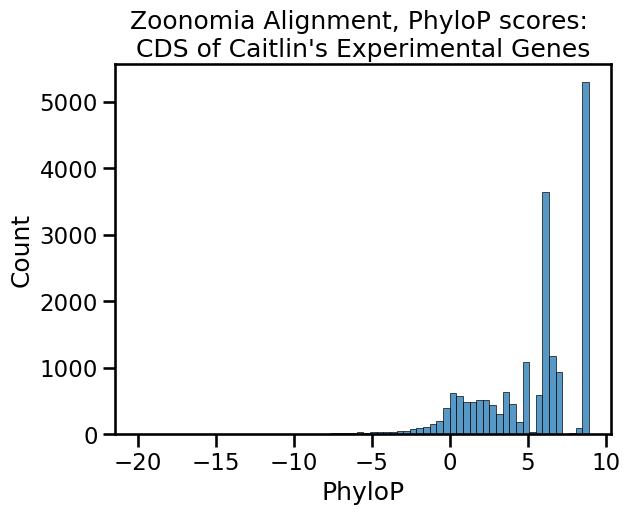

In [49]:
sns.histplot(zoonomia_phyloP["PhyloP"])
plt.title("Zoonomia Alignment, PhyloP scores: \nCDS of Caitlin's Experimental Genes");

In [50]:
# Preparing for variant analysis script
zoonomia_phyloP["chr"] = zoonomia_phyloP["chr"].str[3:].astype(int)
zoonomia_phyloP["start"] = zoonomia_phyloP["start"].astype(int)
zoonomia_phyloP["end"] = zoonomia_phyloP["end"].astype(int)
zoonomia_phyloP

chr     start       end  PhyloP
0       11  31806401  31806402   6.331
1       11  31806402  31806403   8.755
2       11  31806403  31806404   6.331
3       11  31806404  31806405   6.331
4       11  31806405  31806406   5.917
...    ...       ...       ...     ...
19438   15  36892454  36892455   7.067
19439   15  36892455  36892456   6.311
19440   15  36892456  36892457   2.910
19441   15  36892457  36892458   6.253
19442   15  36892458  36892459   8.126

[19443 rows x 4 columns]

In [51]:
zoonomia_phyloP.to_csv("../soto_analysis/raw_files/zoonomia_15.bed", sep = "\t", header = None, index = None)

In [52]:
# Ran variant analysis scripts

In [53]:
cds_phylo_P = []

for ENST in set(cc_names["ENST"]):
    df = pd.read_csv("../soto_analysis/outputs/mutations/cds_zoonomia_15/" + ENST + ".bed", sep = "\t", header = None)
    cds_phylo_P.append(df)

cds_phylo_P = pd.concat(cds_phylo_P)
cds_phylo_P = cds_phylo_P.rename(columns = {4: "ENST", 9: "PhyloP"})
cds_phylo_P

0         1         2       3             ENST  5   6         7  \
0     11  31789933  31789934  P26367  ENST00000241001  -  11  31789933   
1     11  31789934  31789935  P26367  ENST00000241001  -  11  31789934   
2     11  31789935  31789936  P26367  ENST00000241001  -  11  31789935   
3     11  31789936  31789937  P26367  ENST00000241001  -  11  31789936   
4     11  31789937  31789938  P26367  ENST00000241001  -  11  31789937   
...   ..       ...       ...     ...              ... ..  ..       ...   
3604  17   4986217   4986218  O94983  ENST00000348066  -  17   4986217   
3605  17   4986218   4986219  O94983  ENST00000348066  -  17   4986218   
3606  17   4986219   4986220  O94983  ENST00000348066  -  17   4986219   
3607  17   4986220   4986221  O94983  ENST00000348066  -  17   4986220   
3608  17   4986221   4986222  O94983  ENST00000348066  -  17   4986221   

             8  PhyloP  
0     31789934   4.654  
1     31789935   4.739  
2     31789936   3.661  
3     31789937   5.054  
4     31789938   4.738  
...        ...     ...  
3604   4986218   4.922  
3605   4986219   6.356  
3606   4986220   8.897  
3607   4986221   6.331  
3608   4986222   6.356  

[19443 rows x 10 columns]

In [54]:
ad_phylo_P = []

for ENST in set(cc_names["ENST"]):
    df = pd.read_csv("../soto_analysis/outputs/mutations/domains_zoonomia_15/" + ENST + ".bed", sep = "\t", header = None)
    ad_phylo_P.append(df)

ad_phylo_P = pd.concat(ad_phylo_P)
ad_phylo_P = ad_phylo_P.rename(columns = {4: "ENST", 17: "PhyloP"})
dbd_phylo_P = ad_phylo_P[ad_phylo_P[3] == "DBD"]
ad_phylo_P = ad_phylo_P[ad_phylo_P[3] == "AD"]
ad_phylo_P

0         1         2   3             ENST  5  6                7   8  \
381   11  31789936  31789937  AD  ENSG00000007372  .  -  ENST00000241001  11   
382   11  31789937  31789938  AD  ENSG00000007372  .  -  ENST00000241001  11   
383   11  31789938  31789939  AD  ENSG00000007372  .  -  ENST00000241001  11   
384   11  31789939  31789940  AD  ENSG00000007372  .  -  ENST00000241001  11   
385   11  31789940  31789941  AD  ENSG00000007372  .  -  ENST00000241001  11   
...   ..       ...       ...  ..              ... .. ..              ...  ..   
1255  17   4979903   4979904  AD  ENSG00000108509  .  -  ENST00000348066  17   
1256  17   4979904   4979905  AD  ENSG00000108509  .  -  ENST00000348066  17   
1257  17   4979905   4979906  AD  ENSG00000108509  .  -  ENST00000348066  17   
1258  17   4979906   4979907  AD  ENSG00000108509  .  -  ENST00000348066  17   
1259  17   4979907   4979908  AD  ENSG00000108509  .  -  ENST00000348066  17   

             9        10      11               12 13  14        15        16  \
381   31789936  31789937  P26367  ENST00000241001  -  11  31789936  31789937   
382   31789937  31789938  P26367  ENST00000241001  -  11  31789937  31789938   
383   31789938  31789939  P26367  ENST00000241001  -  11  31789938  31789939   
384   31789939  31789940  P26367  ENST00000241001  -  11  31789939  31789940   
385   31789940  31789941  P26367  ENST00000241001  -  11  31789940  31789941   
...        ...       ...     ...              ... ..  ..       ...       ...   
1255   4979903   4979904  O94983  ENST00000348066  -  17   4979903   4979904   
1256   4979904   4979905  O94983  ENST00000348066  -  17   4979904   4979905   
1257   4979905   4979906  O94983  ENST00000348066  -  17   4979905   4979906   
1258   4979906   4979907  O94983  ENST00000348066  -  17   4979906   4979907   
1259   4979907   4979908  O94983  ENST00000348066  -  17   4979907   4979908   

      PhyloP  
381    5.054  
382    4.738  
383    5.851  
384    6.355  
385    3.694  
...      ...  
1255   8.714  
1256   8.714  
1257  -0.935  
1258   8.714  
1259   4.669  

[5145 rows x 18 columns]

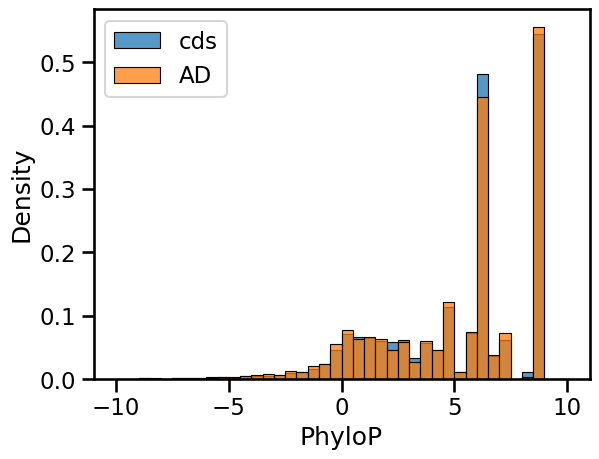

In [55]:
bins = np.arange(-10, 10.1, 0.5)
sns.histplot(cds_phylo_P["PhyloP"], label = "cds", stat = "density", bins = bins)
sns.histplot(ad_phylo_P["PhyloP"], label = "AD", stat = "density", bins = bins)
plt.legend();

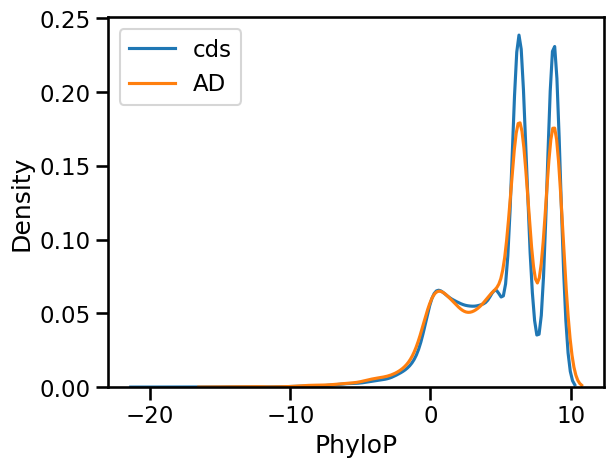

In [56]:
bins = np.arange(-10, 10.1, 0.5)
sns.kdeplot(cds_phylo_P["PhyloP"], label = "cds")
sns.kdeplot(ad_phylo_P["PhyloP"], label = "AD")
plt.legend();

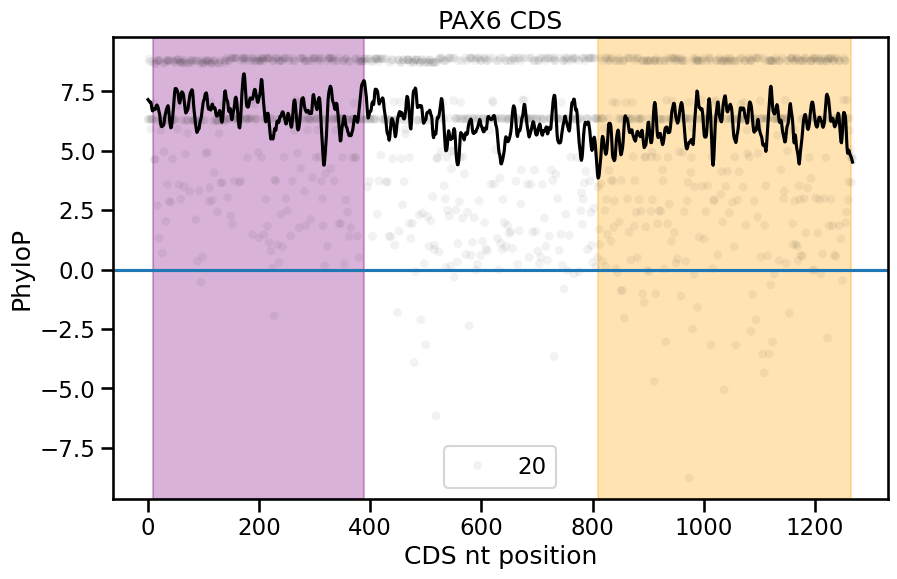

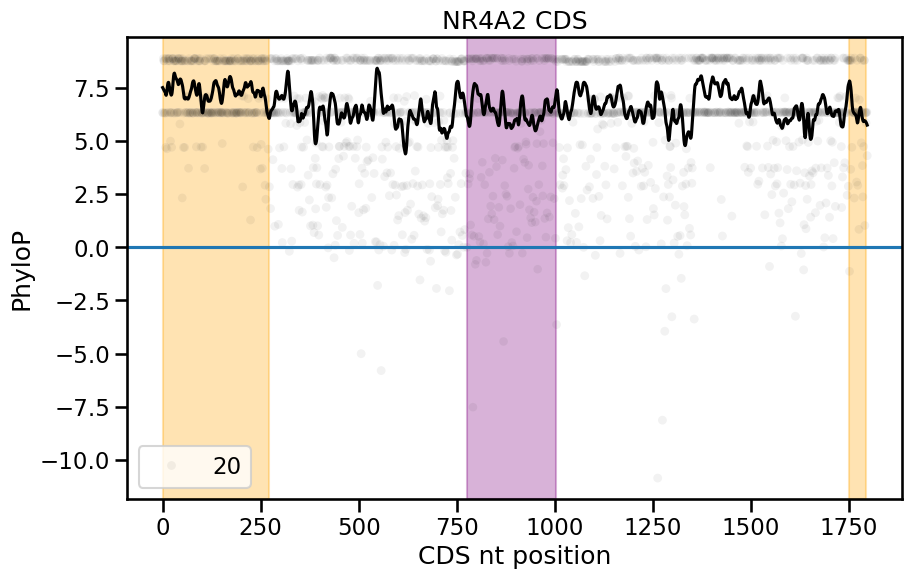

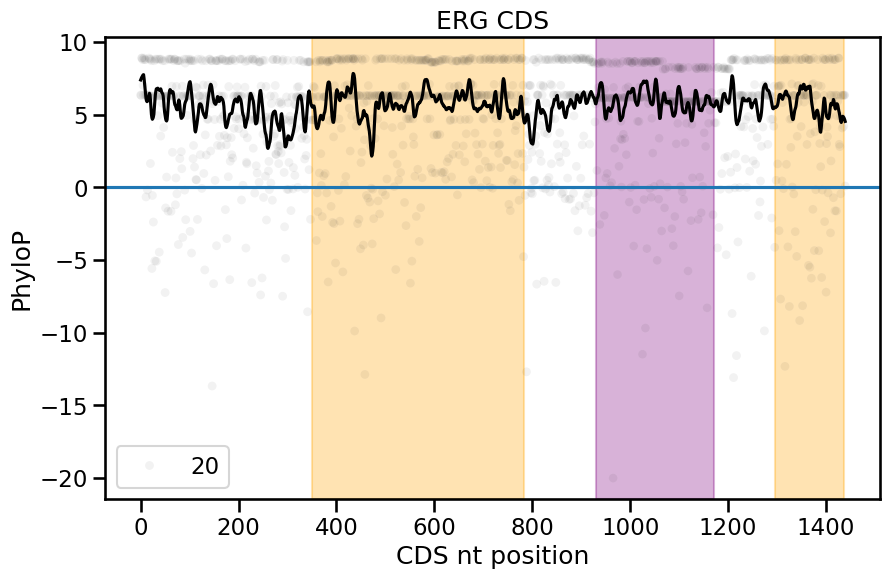

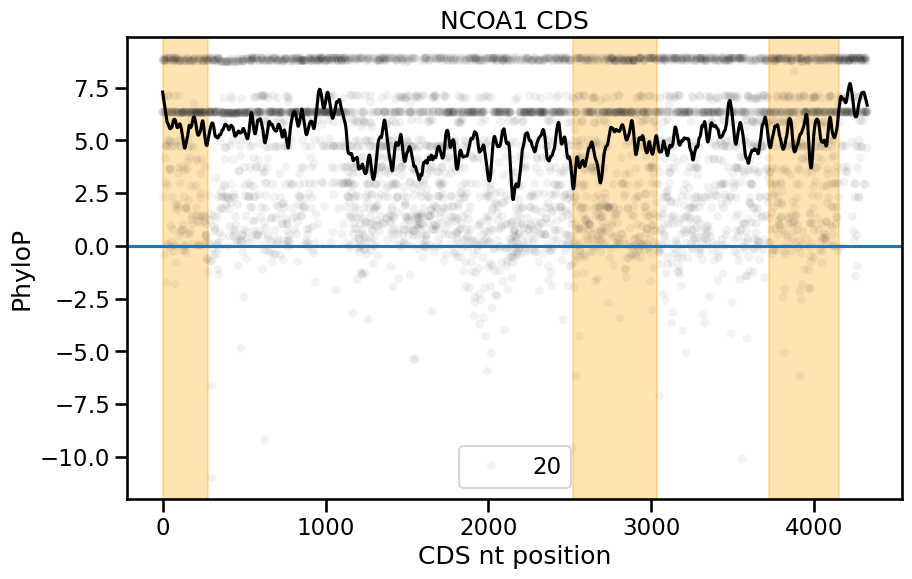

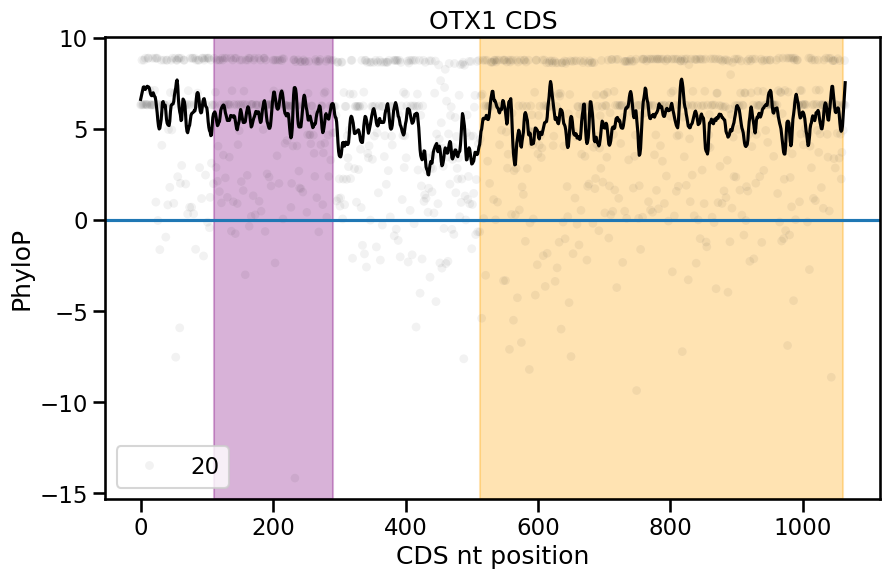

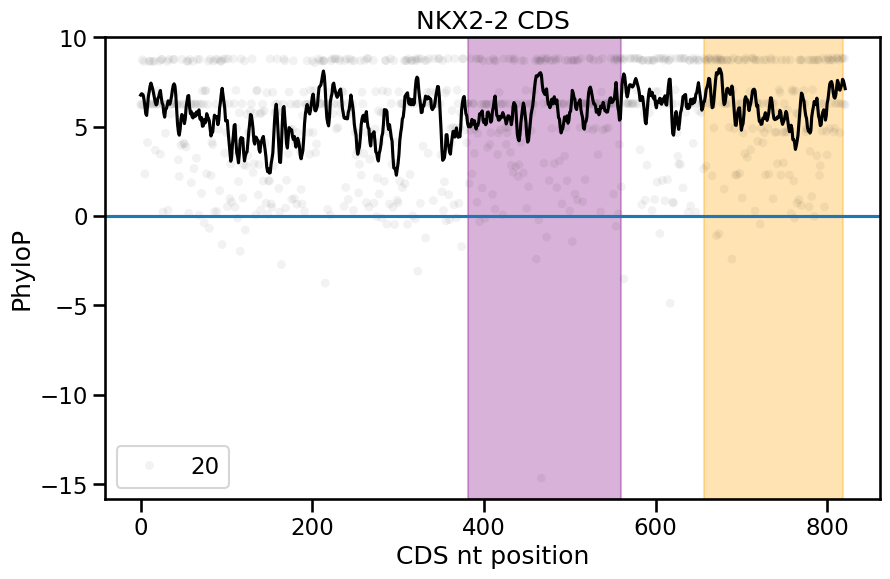

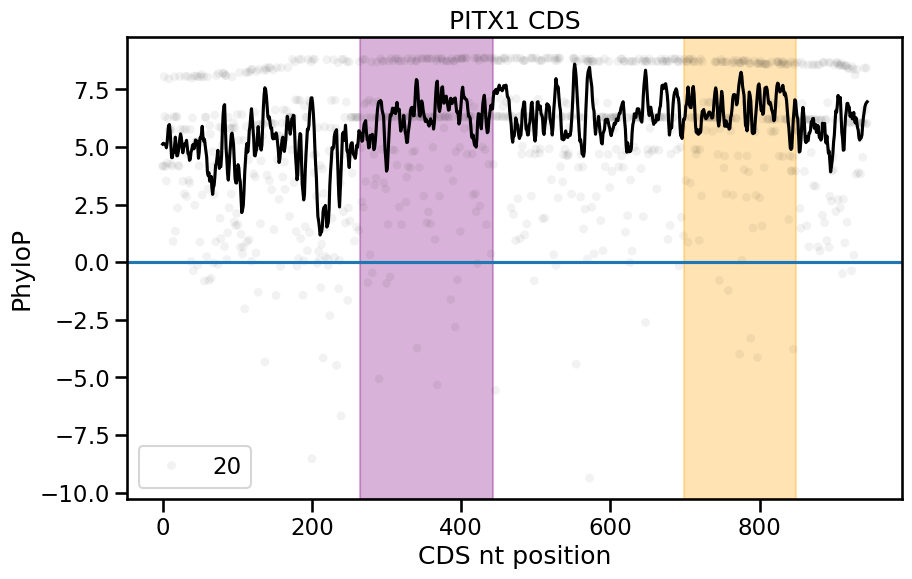

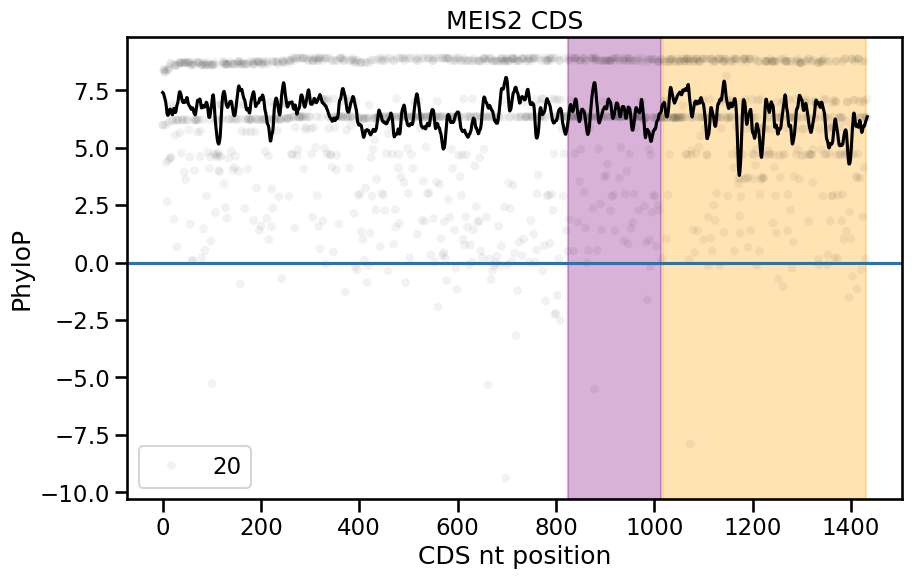

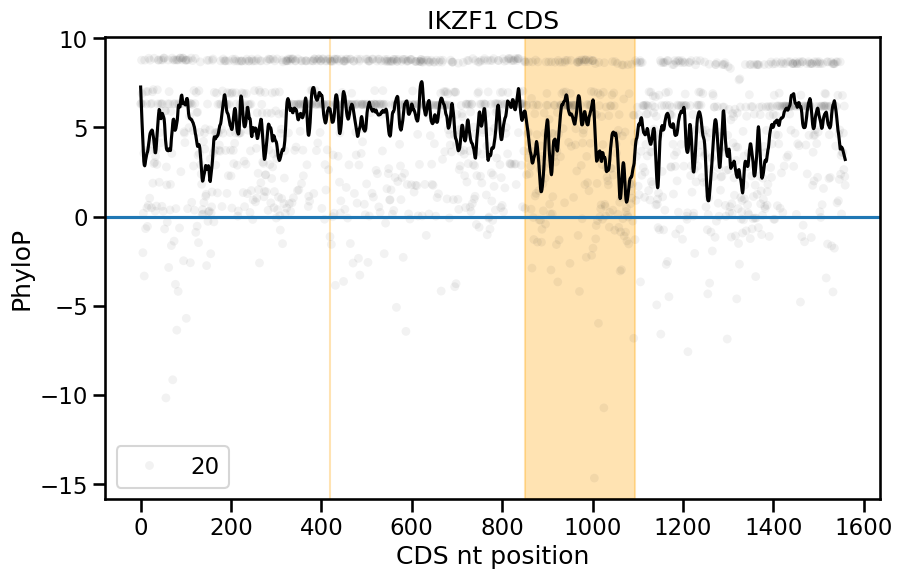

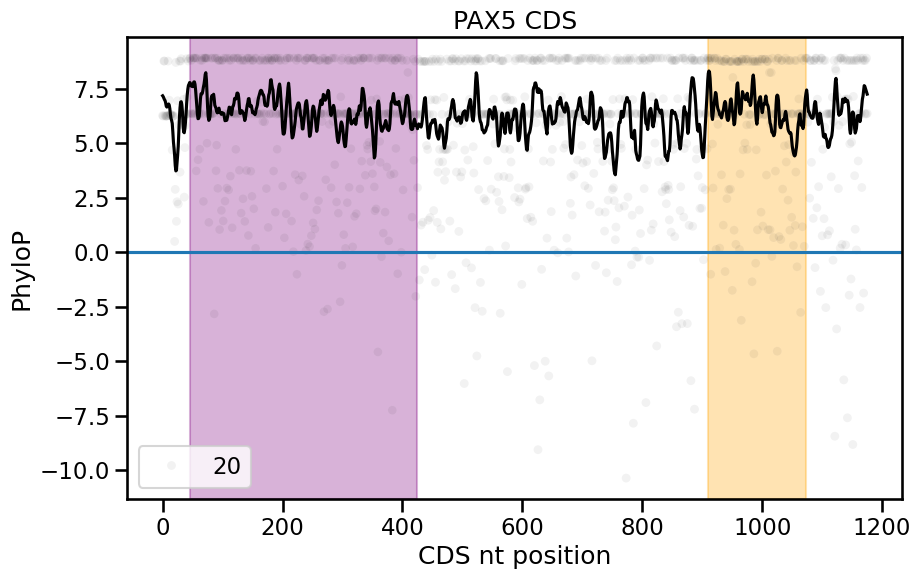

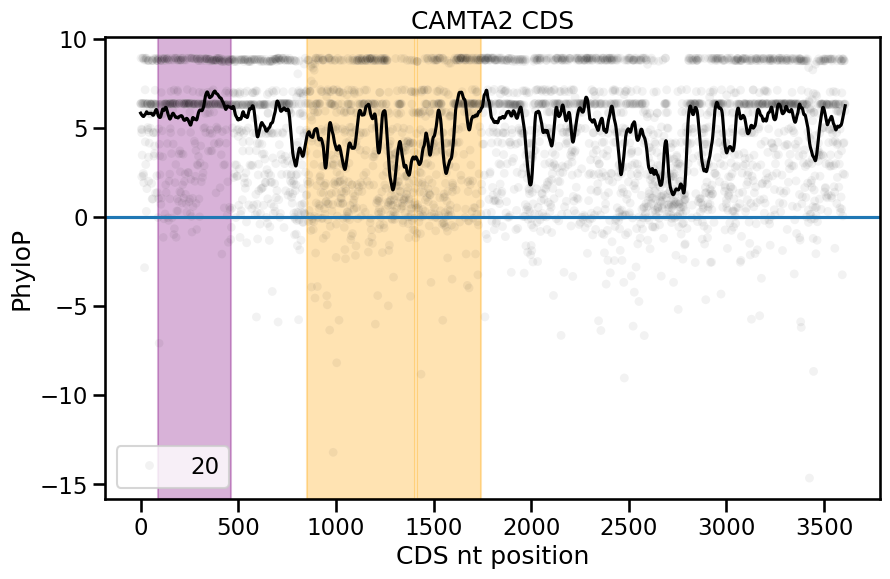

In [114]:
#https://www.geeksforgeeks.org/python-make-a-list-of-intervals-with-sequential-numbers/
def intervals_extract(iterable):
     
    iterable = sorted(set(iterable))
    for key, group in itertools.groupby(enumerate(iterable),
    lambda t: t[1] - t[0]):
        group = list(group)
        yield [group[0][1], group[-1][1]]

tfs_tbl = pd.read_csv("../soto_analysis/outputs/TFs_table_proteins.txt", sep = "\t")
for ENST in set(cc_names["ENST"]):
    #display(tfs_tbl[tfs_tbl["ENST"] == ENST])
    ENST_phylo_P = cds_phylo_P[cds_phylo_P["ENST"] == ENST]
    # If negative strand, sort ascending = False
    # Else, sort ascending = True
    if ENST_phylo_P[5].iloc[0] == "-":
        ascending = False
    else: 
        ascending = True
    ENST_phylo_P = ENST_phylo_P.sort_values(by = 1, ascending = ascending)
    uniprotID = cc_names[cc_names["ENST"] == ENST]["uniprotID"].iloc[0]
    domains = pd.read_csv("../soto_analysis/outputs/mutations/domains_zoonomia_15/" + ENST + ".bed", sep = "\t", header = None)
    domains = domains[[0, 1, 2, 3]]
    ENST_phylo_P_with_domains = pd.merge(ENST_phylo_P, domains, how = "left", on = [0, 1, 2])
    ENST_phylo_P_with_domains = ENST_phylo_P_with_domains.fillna(0)
    ENST_phylo_P_with_domains["cds_nt"] = np.arange(len(ENST_phylo_P_with_domains))
    #display(ENST_phylo_P_with_domains)


    # Apply lowess smoothing
    gene = cc_names[cc_names["ENST"] == ENST]["Gene"].iloc[0]
    
    smoothed = lowess(ENST_phylo_P_with_domains['PhyloP'], ENST_phylo_P_with_domains["cds_nt"], frac=0.01)  # Adjust frac for smoothness
    color_map = {
        'AD': 'orange',
        'DBD': 'purple'
    }
    
    # Create a new DataFrame for smoothed data
    smoothed_df = pd.DataFrame(smoothed, columns=["cds_nt", 'smoothed'])
    
    # Plot
    plt.figure(figsize=(10, 6))
    
    
    # Create background color blocks based on '3_y'
    for value, color in color_map.items():
        subset = ENST_phylo_P_with_domains[ENST_phylo_P_with_domains['3_y'] == value]
        intervals = list(intervals_extract(subset["cds_nt"]))
        
        for interval in intervals:
            plt.axvspan(interval[0], interval[1], color=color, alpha=0.3)

    sns.scatterplot(data=ENST_phylo_P_with_domains, x="cds_nt", y='PhyloP', color='black', alpha = 0.05, size = 20)
    sns.lineplot(data=smoothed_df, x="cds_nt", y='smoothed', color='black')

    #plt.ylim(0, 10)
    plt.axhline(0)
    # Add labels and legend
    #print(ENST)
    plt.title(gene + ' CDS')
    plt.xlabel('CDS nt position')  
    # plt.ylabel('PhyloP Score')
    #plt.legend(title='Domain Type')
    plt.show()


In [58]:
ad_phylo_P

0         1         2   3             ENST  5  6                7   8  \
381   11  31789936  31789937  AD  ENSG00000007372  .  -  ENST00000241001  11   
382   11  31789937  31789938  AD  ENSG00000007372  .  -  ENST00000241001  11   
383   11  31789938  31789939  AD  ENSG00000007372  .  -  ENST00000241001  11   
384   11  31789939  31789940  AD  ENSG00000007372  .  -  ENST00000241001  11   
385   11  31789940  31789941  AD  ENSG00000007372  .  -  ENST00000241001  11   
...   ..       ...       ...  ..              ... .. ..              ...  ..   
1255  17   4979903   4979904  AD  ENSG00000108509  .  -  ENST00000348066  17   
1256  17   4979904   4979905  AD  ENSG00000108509  .  -  ENST00000348066  17   
1257  17   4979905   4979906  AD  ENSG00000108509  .  -  ENST00000348066  17   
1258  17   4979906   4979907  AD  ENSG00000108509  .  -  ENST00000348066  17   
1259  17   4979907   4979908  AD  ENSG00000108509  .  -  ENST00000348066  17   

             9        10      11               12 13  14        15        16  \
381   31789936  31789937  P26367  ENST00000241001  -  11  31789936  31789937   
382   31789937  31789938  P26367  ENST00000241001  -  11  31789937  31789938   
383   31789938  31789939  P26367  ENST00000241001  -  11  31789938  31789939   
384   31789939  31789940  P26367  ENST00000241001  -  11  31789939  31789940   
385   31789940  31789941  P26367  ENST00000241001  -  11  31789940  31789941   
...        ...       ...     ...              ... ..  ..       ...       ...   
1255   4979903   4979904  O94983  ENST00000348066  -  17   4979903   4979904   
1256   4979904   4979905  O94983  ENST00000348066  -  17   4979904   4979905   
1257   4979905   4979906  O94983  ENST00000348066  -  17   4979905   4979906   
1258   4979906   4979907  O94983  ENST00000348066  -  17   4979906   4979907   
1259   4979907   4979908  O94983  ENST00000348066  -  17   4979907   4979908   

      PhyloP  
381    5.054  
382    4.738  
383    5.851  
384    6.355  
385    3.694  
...      ...  
1255   8.714  
1256   8.714  
1257  -0.935  
1258   8.714  
1259   4.669  

[5145 rows x 18 columns]

In [59]:
dbd_phylo_P

0         1         2    3             ENST  5  6                7   8  \
0    11  31800823  31800824  DBD  ENSG00000007372  .  -  ENST00000241001  11   
1    11  31800824  31800825  DBD  ENSG00000007372  .  -  ENST00000241001  11   
2    11  31800825  31800826  DBD  ENSG00000007372  .  -  ENST00000241001  11   
3    11  31800826  31800827  DBD  ENSG00000007372  .  -  ENST00000241001  11   
4    11  31800827  31800828  DBD  ENSG00000007372  .  -  ENST00000241001  11   
..   ..       ...       ...  ...              ... .. ..              ...  ..   
373  17   4985922   4985923  DBD  ENSG00000108509  .  -  ENST00000348066  17   
374  17   4985923   4985924  DBD  ENSG00000108509  .  -  ENST00000348066  17   
375  17   4985924   4985925  DBD  ENSG00000108509  .  -  ENST00000348066  17   
376  17   4985925   4985926  DBD  ENSG00000108509  .  -  ENST00000348066  17   
377  17   4985926   4985927  DBD  ENSG00000108509  .  -  ENST00000348066  17   

            9        10      11               12 13  14        15        16  \
0    31800823  31800824  P26367  ENST00000241001  -  11  31800823  31800824   
1    31800824  31800825  P26367  ENST00000241001  -  11  31800824  31800825   
2    31800825  31800826  P26367  ENST00000241001  -  11  31800825  31800826   
3    31800826  31800827  P26367  ENST00000241001  -  11  31800826  31800827   
4    31800827  31800828  P26367  ENST00000241001  -  11  31800827  31800828   
..        ...       ...     ...              ... ..  ..       ...       ...   
373   4985922   4985923  O94983  ENST00000348066  -  17   4985922   4985923   
374   4985923   4985924  O94983  ENST00000348066  -  17   4985923   4985924   
375   4985924   4985925  O94983  ENST00000348066  -  17   4985924   4985925   
376   4985925   4985926  O94983  ENST00000348066  -  17   4985925   4985926   
377   4985926   4985927  O94983  ENST00000348066  -  17   4985926   4985927   

     PhyloP  
0     8.871  
1     6.312  
2     8.764  
3     8.764  
4     6.338  
..      ...  
373   8.874  
374   6.314  
375  -0.040  
376   8.874  
377   8.767  

[2340 rows x 18 columns]

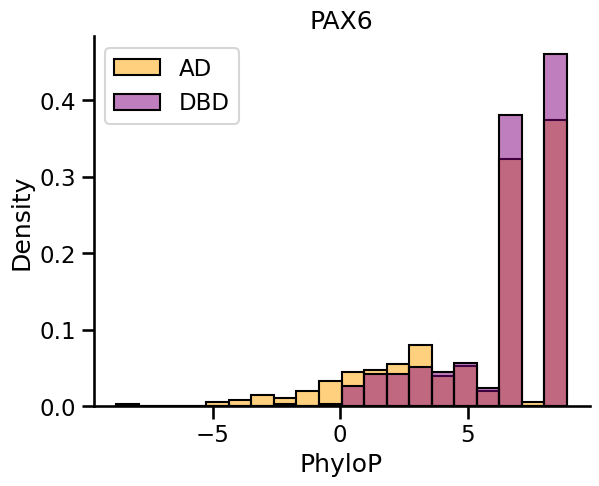

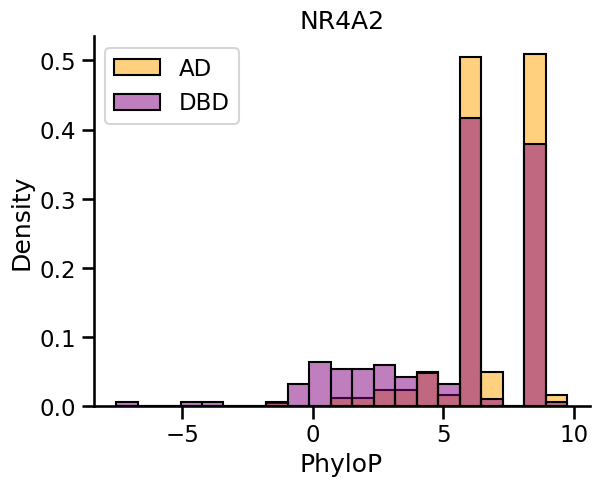

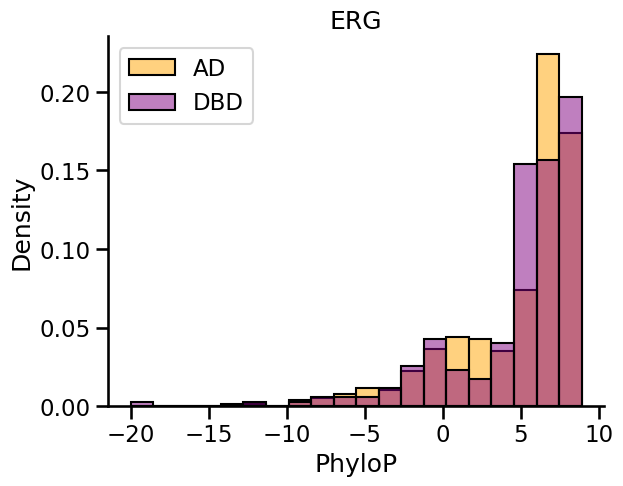

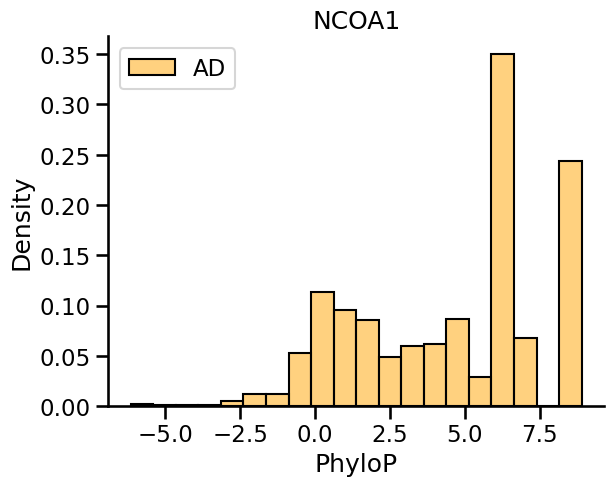

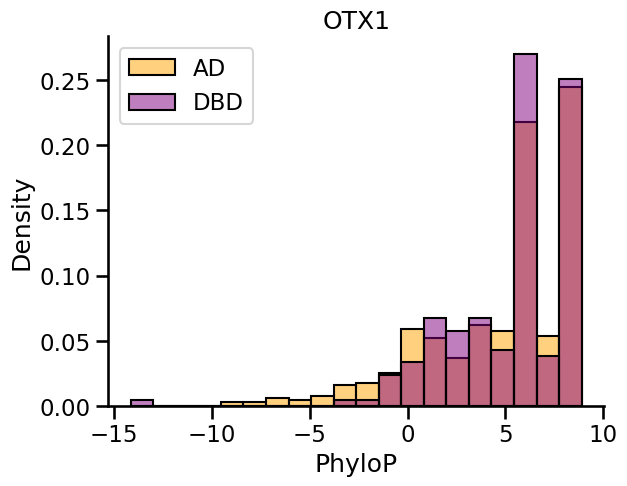

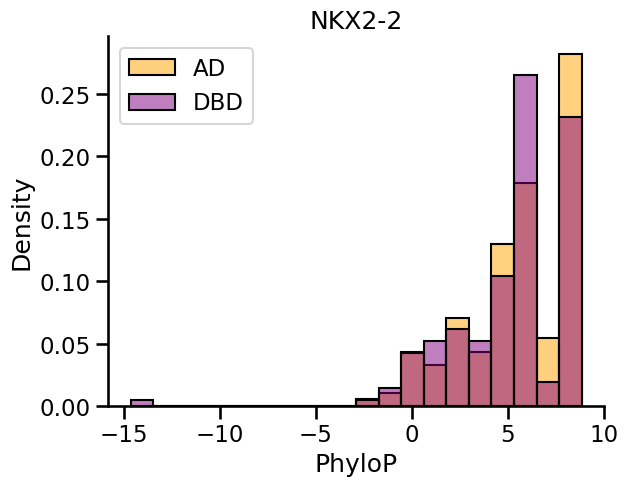

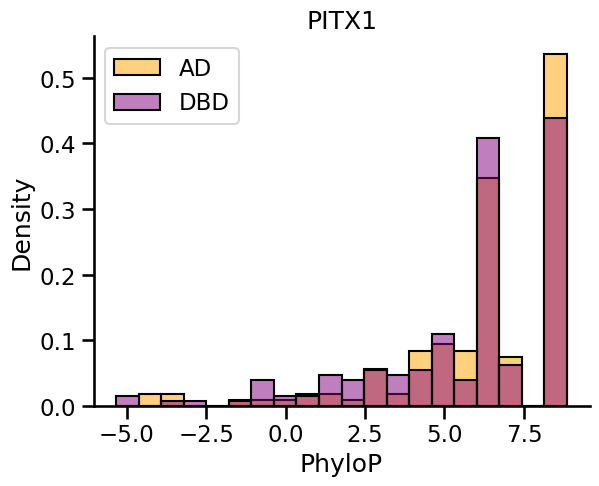

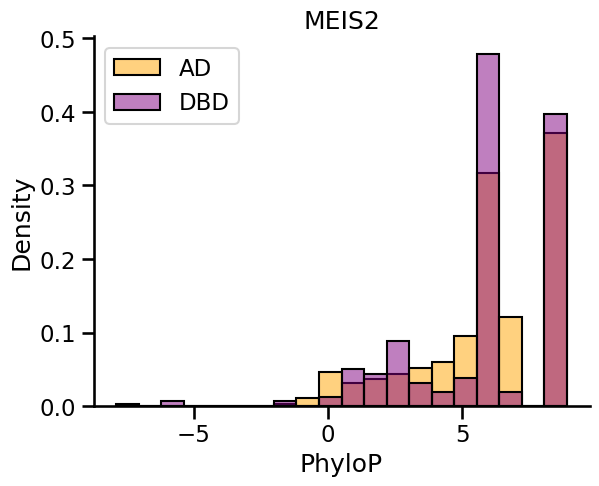

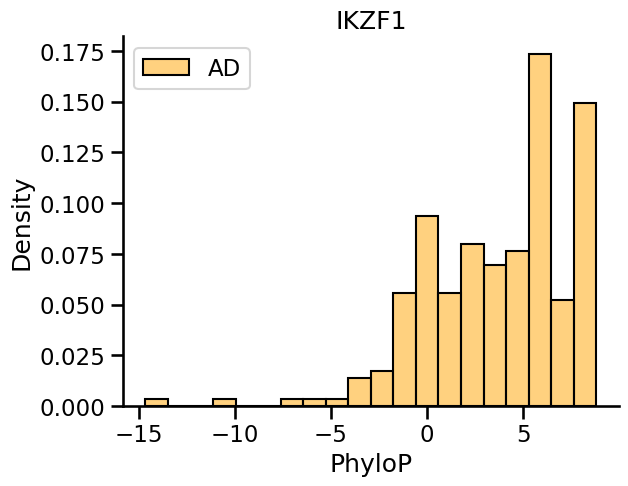

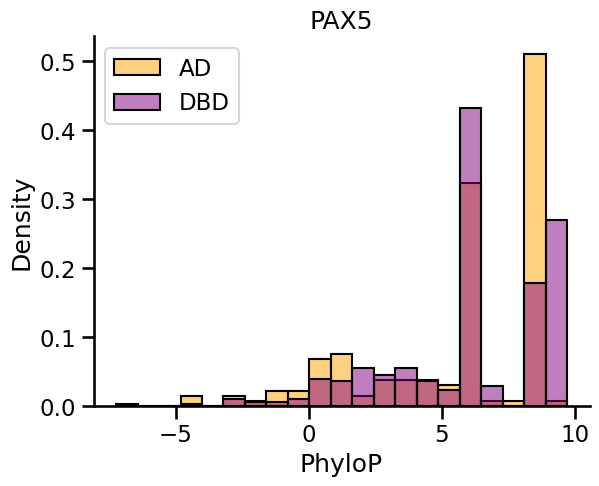

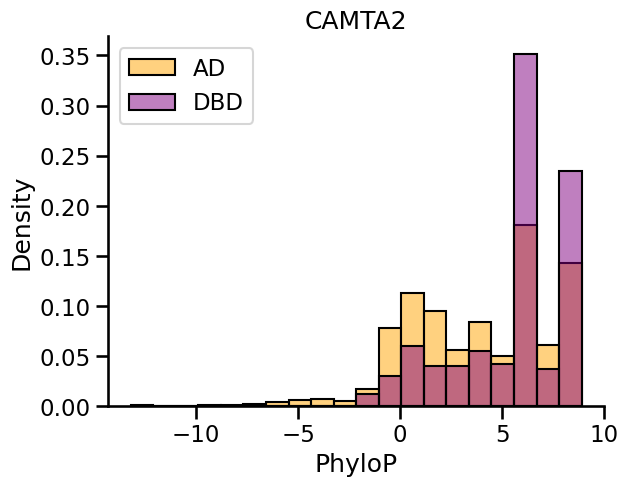

In [118]:
sns.set_context('talk')
for ENST in set(cc_names["ENST"]):
    gene = cc_names[cc_names["ENST"] == ENST]["Gene"].iloc[0]
    AD_rows = ad_phylo_P[ad_phylo_P[7] == ENST]["PhyloP"]
    DBD_rows = dbd_phylo_P[dbd_phylo_P[7] == ENST]["PhyloP"]

    if len(AD_rows) > 0 and len(DBD_rows) > 0:
        min_both = min(min(AD_rows), min(DBD_rows))
        max_both = max(max(AD_rows), max(DBD_rows)) 
        step = (max_both - min_both) / 20
        bins = np.arange(min_both, max_both + step, step)
    else:
        step = (max(AD_rows) - min(AD_rows)) / 20
        bins = np.arange(min(AD_rows), max(AD_rows) + step, step) 
    sns.histplot(AD_rows, label = "AD", stat = "density", bins = bins, color = "orange", alpha = 0.5)
    sns.histplot(DBD_rows, label = "DBD", stat = "density", bins = bins, color = "purple", alpha = 0.5)
    sns.despine()
    plt.title(gene)
    plt.legend()
    plt.show();

In [61]:
lambert_TFs = pd.read_csv("../data/LambertTFs.csv", index_col = 0)
lambert_TFs["uniprotID"] = lambert_TFs["GeneName"].str.split("|").str[1]
lambert_TFs

GeneName  \
0      sp|P23511|NFYA_HUMAN   
1       sp|Q96QS3|ARX_HUMAN   
2     sp|P31270|HXA11_HUMAN   
3     sp|P50221|MEOX1_HUMAN   
4      sp|P57073|SOX8_HUMAN   
...                     ...   
1603  sp|P35227|PCGF2_HUMAN   
1604  sp|Q9BS34|ZN670_HUMAN   
1605   sp|P17098|ZNF8_HUMAN   
1606  sp|Q9UJW7|ZN229_HUMAN   
1607  sp|Q9Y5X4|NR2E3_HUMAN   

                                             ProteinSeq uniprotID  
0     MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...    P23511  
1     MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...    Q96QS3  
2     MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...    P31270  
3     MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...    P50221  
4     MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...    P57073  
...                                                 ...       ...  
1603  MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...    P35227  
1604  MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...    Q9BS34  
1605  MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...    P17098  
1606  METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...    Q9UJW7  
1607  METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...    Q9Y5X4  

[1608 rows x 3 columns]

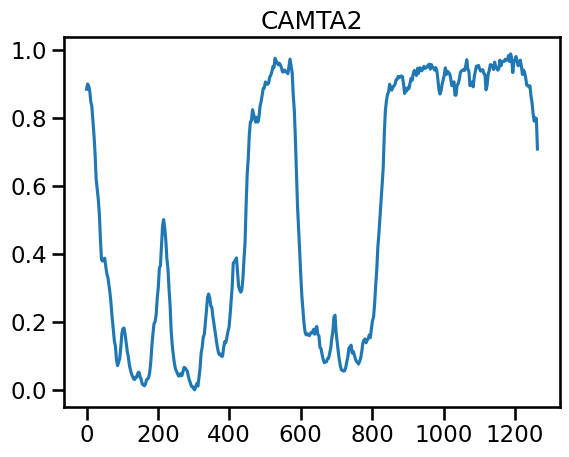

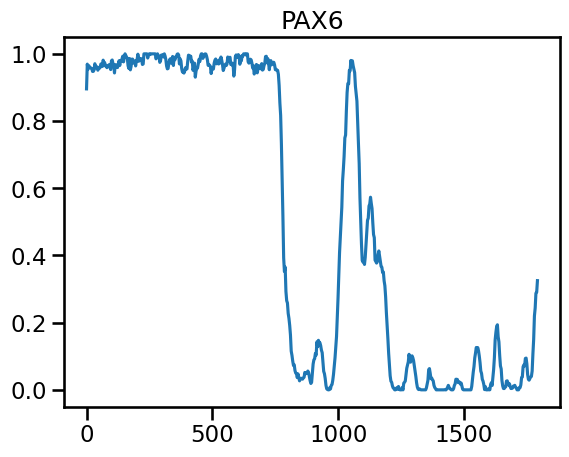

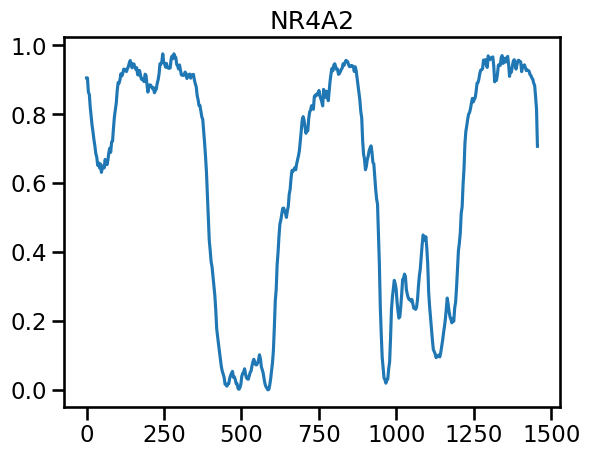

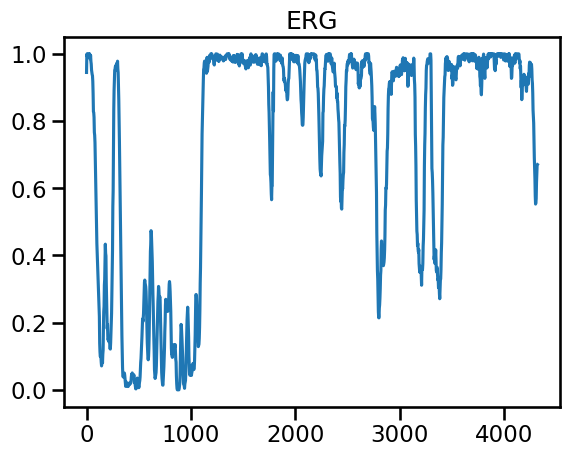

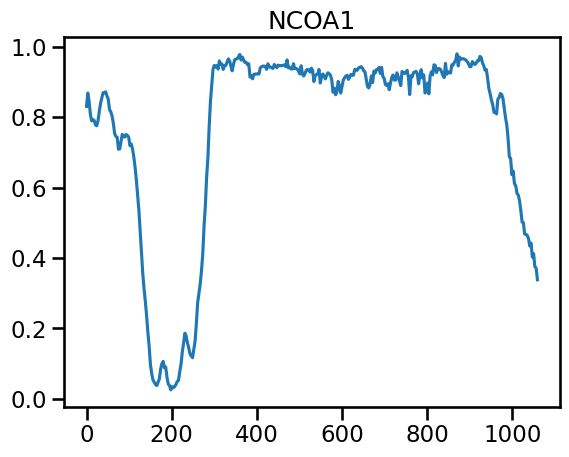

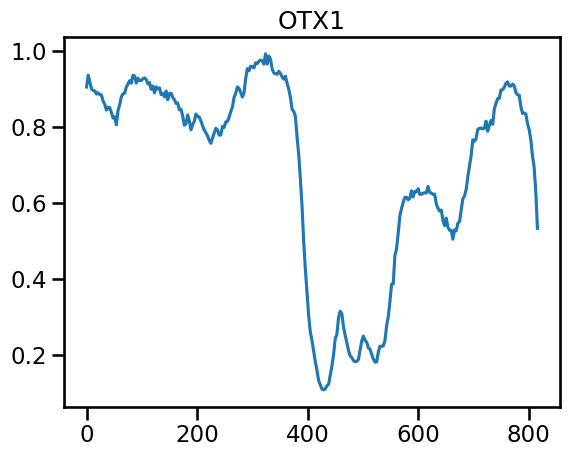

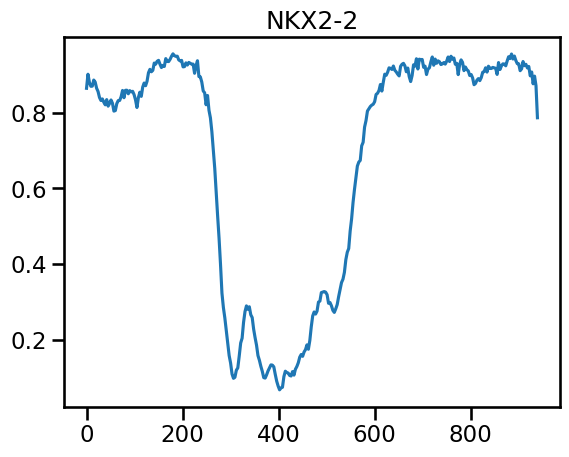

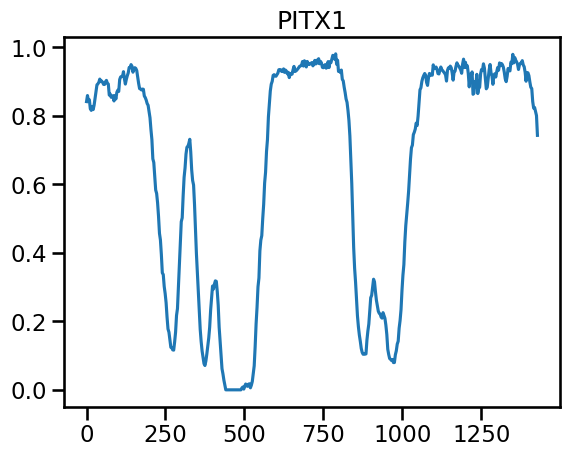

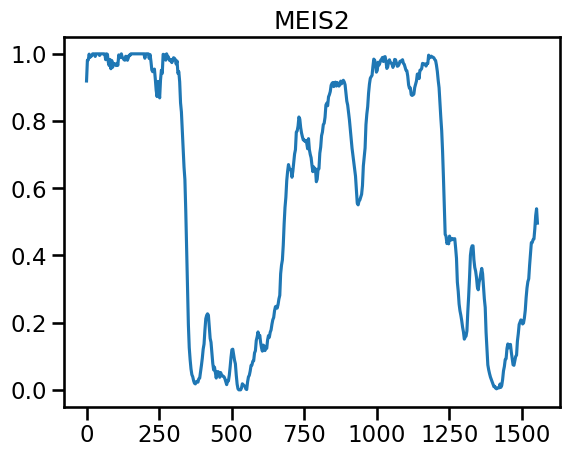

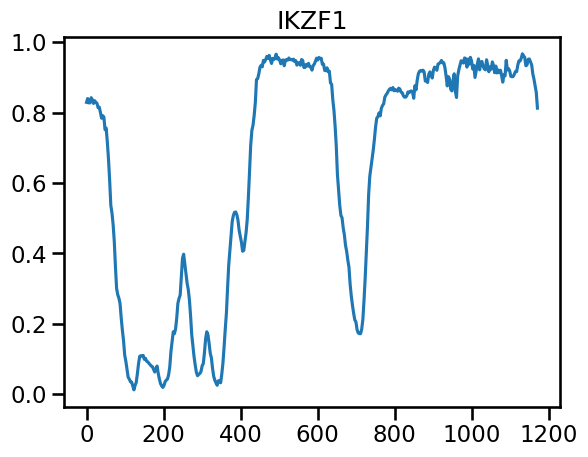

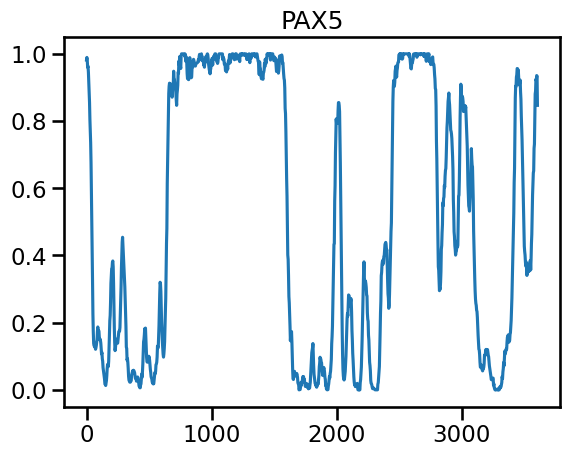

In [62]:
for ENST in set(cc_names["ENST"]):
    plt.title(gene)
    #print(uniprotID)
    gene = cc_names[cc_names["ENST"] == ENST]["Gene"].iloc[0]
    uniprotID = cc_names[cc_names["ENST"] == ENST]["uniprotID"].iloc[0]
    TF_seq = lambert_TFs[lambert_TFs["uniprotID"] == uniprotID]["ProteinSeq"].iloc[0]
    disorder = meta.predict_disorder(TF_seq)
    sns.lineplot(x = np.arange(0, len(disorder) * 3, 3), y = disorder)
    plt.show()
    #print(TF_seq)
    print()

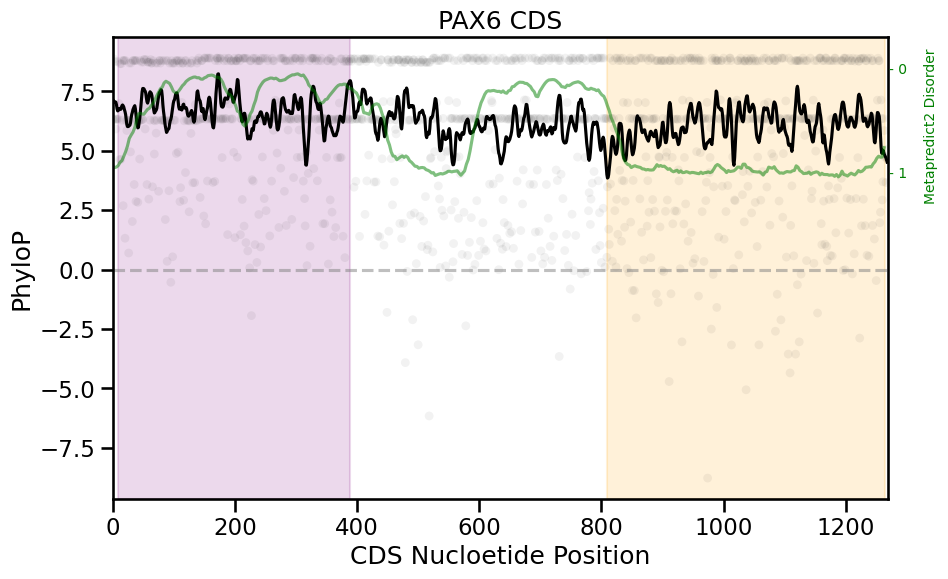

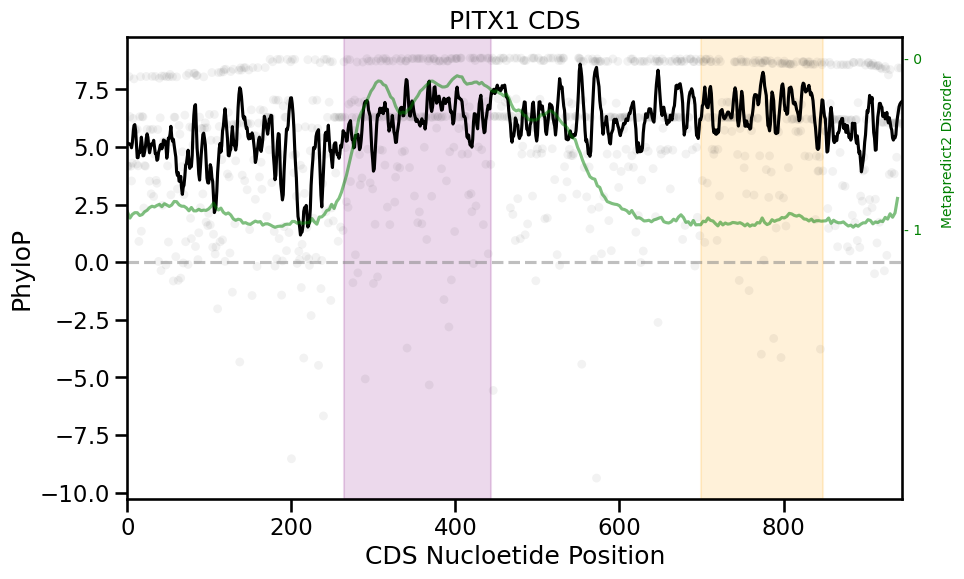

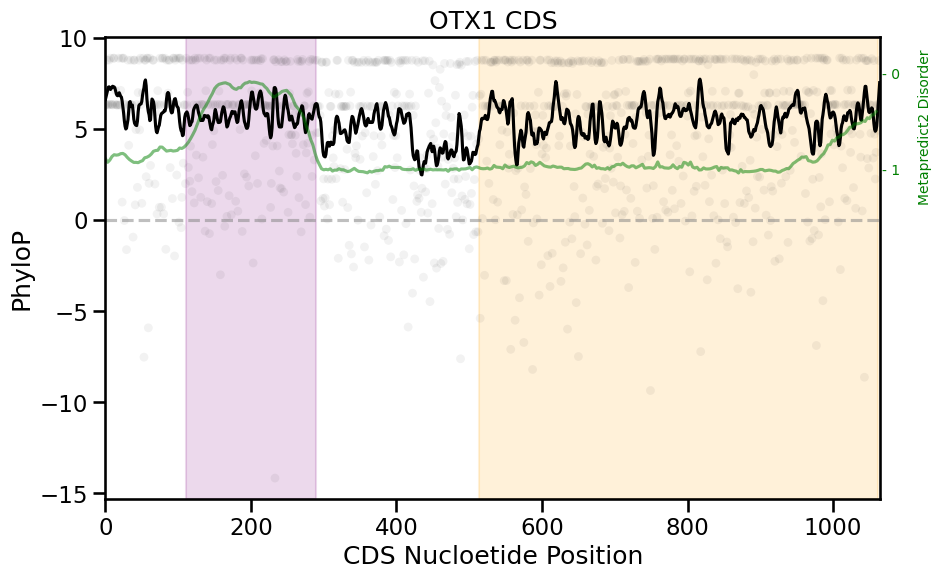

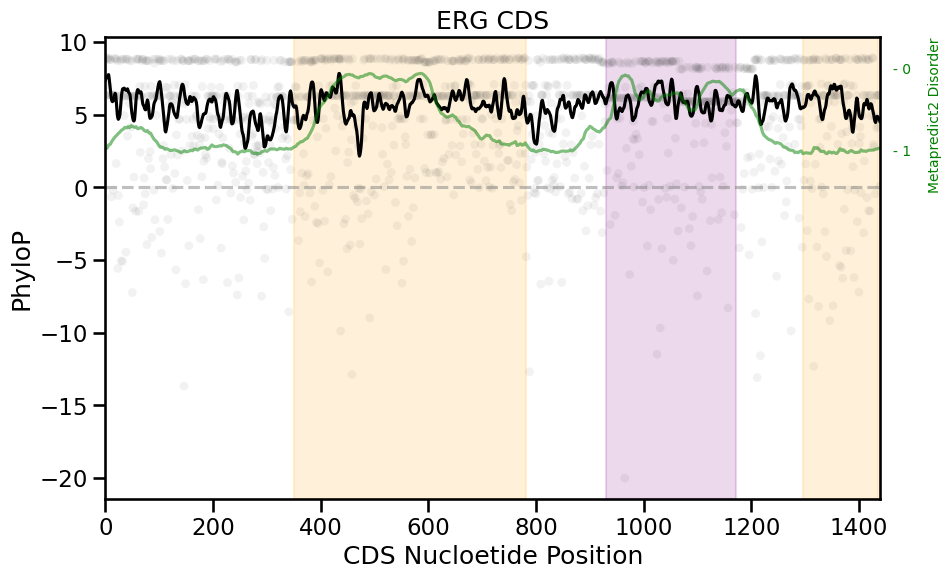

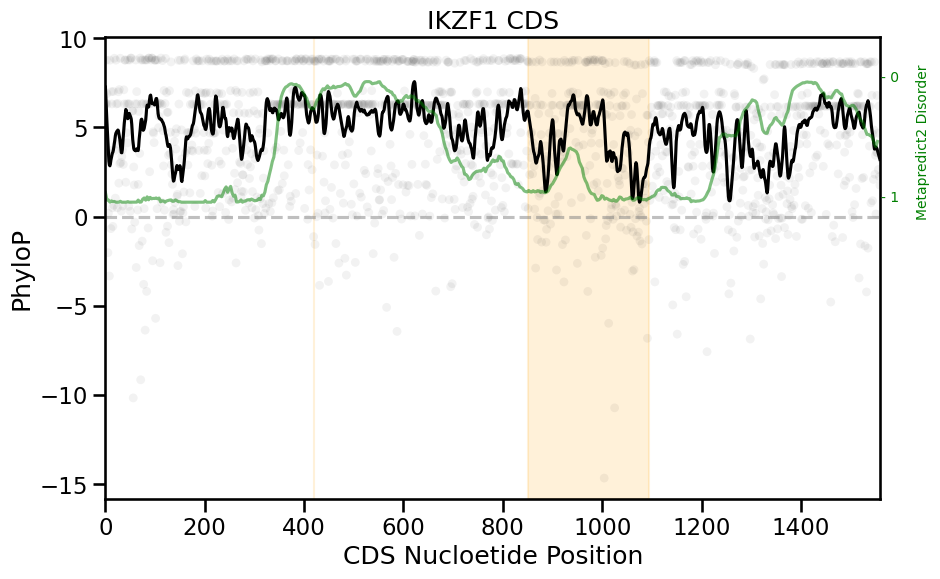

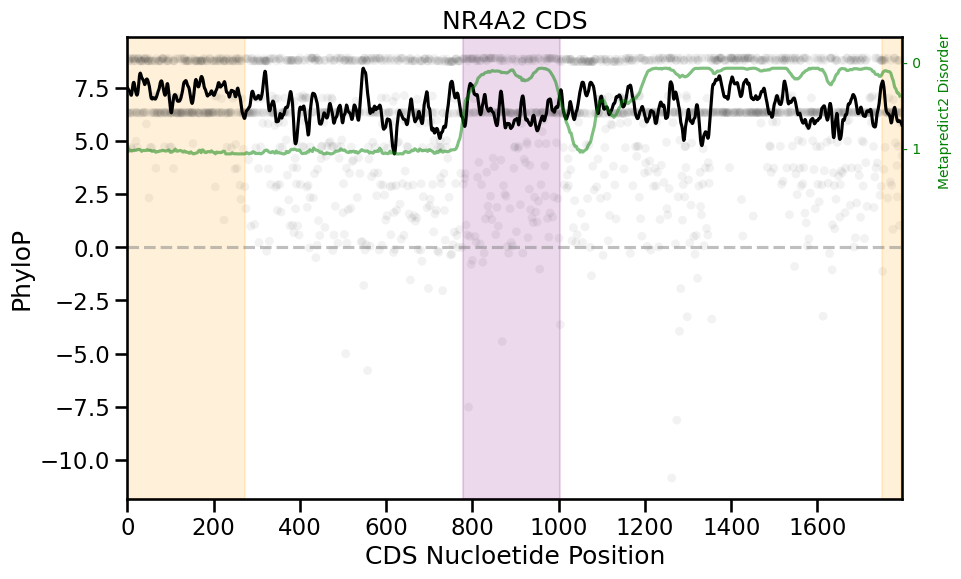

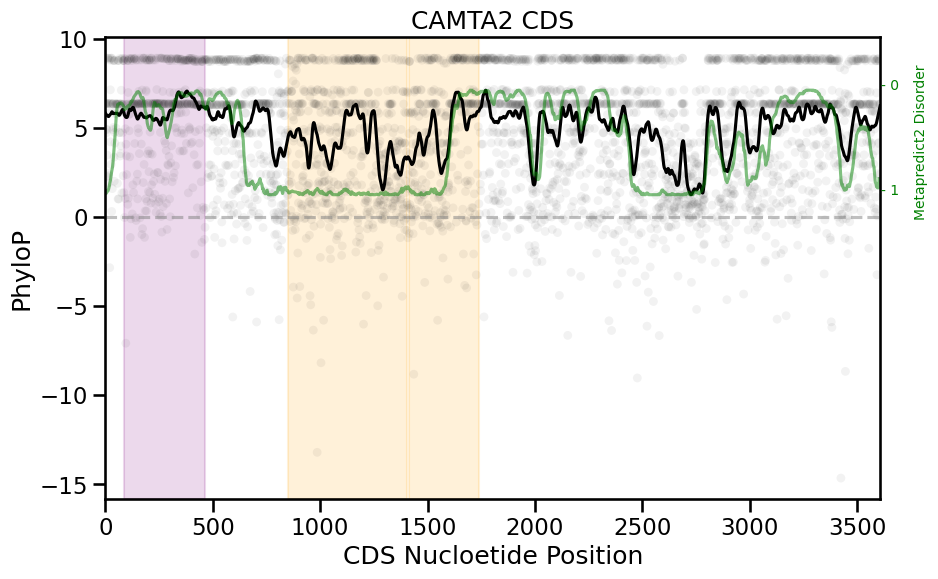

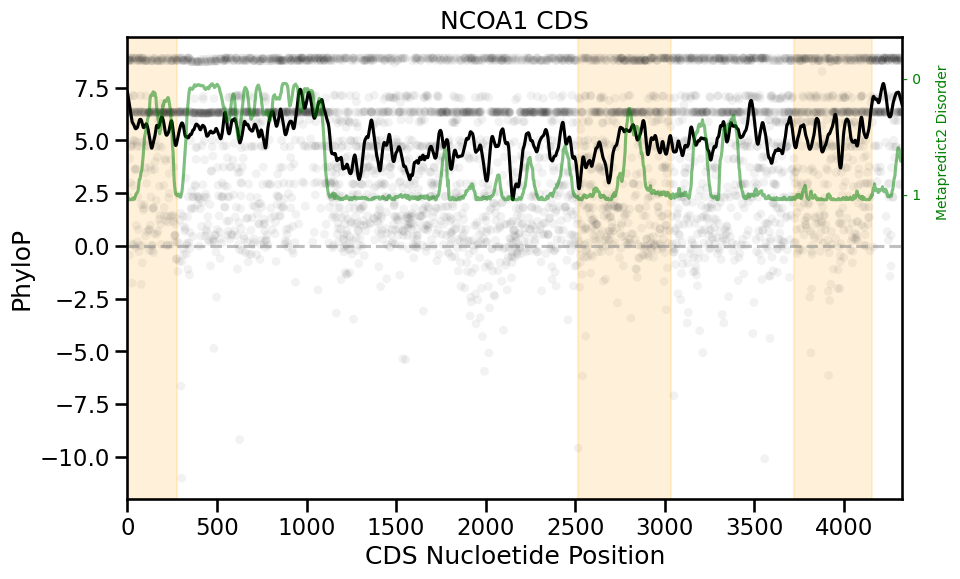

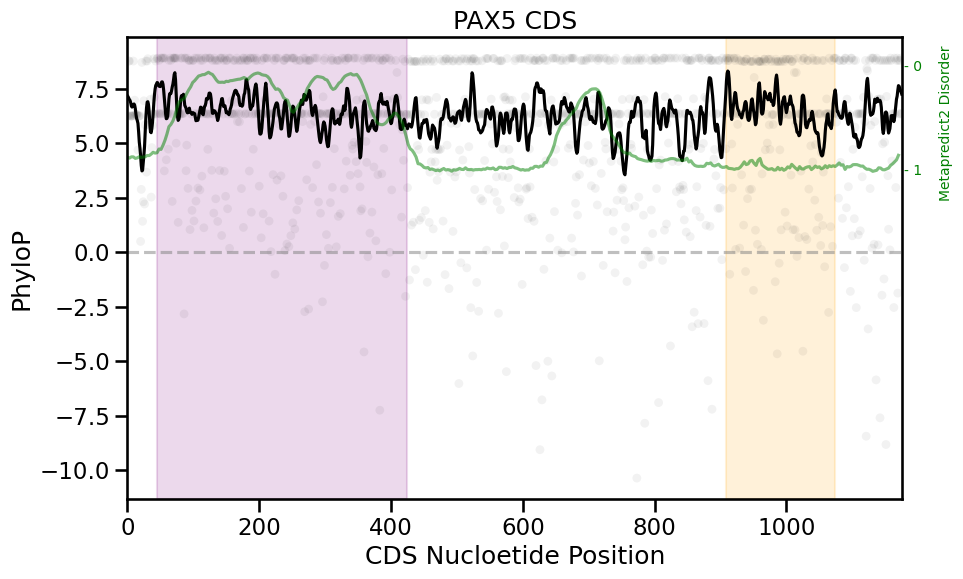

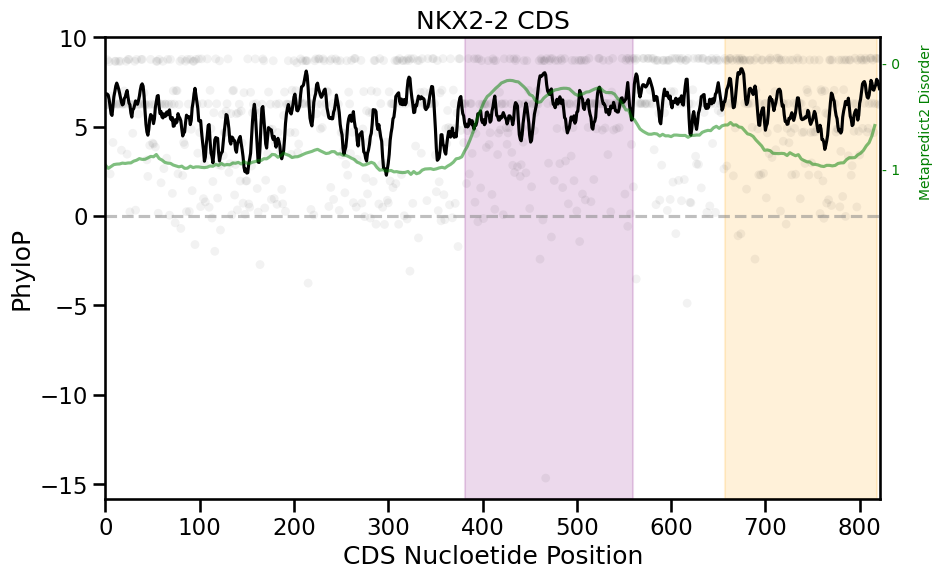

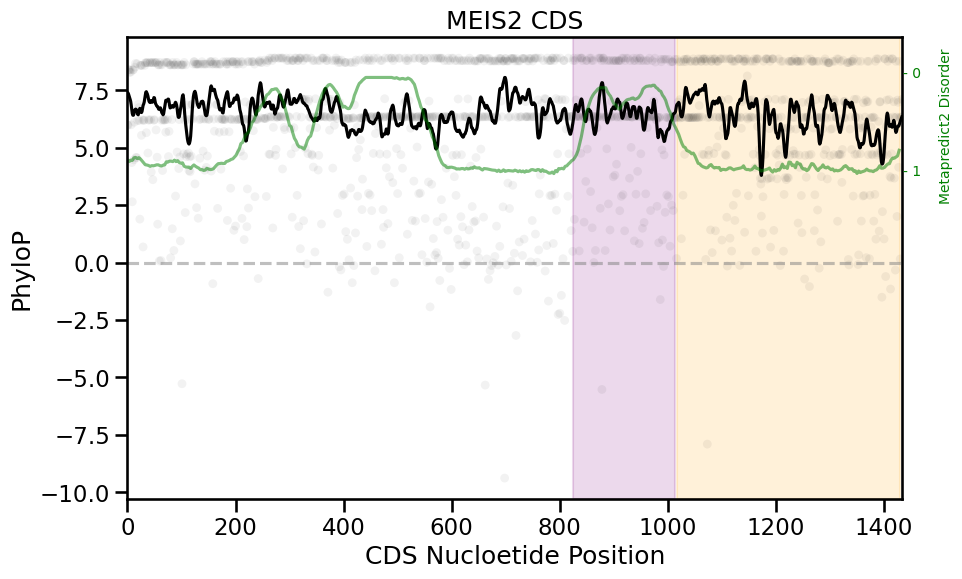

In [116]:
#https://www.geeksforgeeks.org/python-make-a-list-of-intervals-with-sequential-numbers/
def intervals_extract(iterable):
     
    iterable = sorted(set(iterable))
    for key, group in itertools.groupby(enumerate(iterable),
    lambda t: t[1] - t[0]):
        group = list(group)
        yield [group[0][1], group[-1][1]]

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

sns.set_context('talk')

tfs_tbl = pd.read_csv("../soto_analysis/outputs/TFs_table_proteins.txt", sep = "\t")
for ENST in cc_names.sort_values(by = "ENST")["ENST"].drop_duplicates():
    #display(tfs_tbl[tfs_tbl["ENST"] == ENST])
    ENST_phylo_P = cds_phylo_P[cds_phylo_P["ENST"] == ENST]
    # If negative strand, sort ascending = False
    # Else, sort ascending = True
    if ENST_phylo_P[5].iloc[0] == "-":
        ascending = False
    else: 
        ascending = True
    ENST_phylo_P = ENST_phylo_P.sort_values(by = 1, ascending = ascending)
    uniprotID = cc_names[cc_names["ENST"] == ENST]["uniprotID"].iloc[0]
    domains = pd.read_csv("../soto_analysis/outputs/mutations/domains_zoonomia_15/" + ENST + ".bed", sep = "\t", header = None)
    domains = domains[[0, 1, 2, 3]]
    ENST_phylo_P_with_domains = pd.merge(ENST_phylo_P, domains, how = "left", on = [0, 1, 2])
    ENST_phylo_P_with_domains = ENST_phylo_P_with_domains.fillna(0)
    ENST_phylo_P_with_domains["cds_nt"] = np.arange(len(ENST_phylo_P_with_domains))
    #display(ENST_phylo_P_with_domains)


    # Apply lowess smoothing
    gene = cc_names[cc_names["ENST"] == ENST]["Gene"].iloc[0]
    
    smoothed = lowess(ENST_phylo_P_with_domains['PhyloP'], ENST_phylo_P_with_domains["cds_nt"], frac=0.01)  # Adjust frac for smoothness
    color_map = {
        'AD': 'orange',
        'DBD': 'purple'
    }
    
    # Create a new DataFrame for smoothed data
    smoothed_df = pd.DataFrame(smoothed, columns=["cds_nt", 'smoothed'])
    
    # Plot
    plt.figure(figsize=(10, 6))
    
    
    # Create background color blocks based on '3_y'
    for value, color in color_map.items():
        subset = ENST_phylo_P_with_domains[ENST_phylo_P_with_domains['3_y'] == value]
        intervals = list(intervals_extract(subset["cds_nt"]))
        
        for interval in intervals:
            plt.axvspan(interval[0], interval[1], color=color, alpha=0.15)

    sns.scatterplot(data=ENST_phylo_P_with_domains, x="cds_nt", y='PhyloP', color='black', alpha = 0.05, size = 20, legend = False)
    #plt.legend().remove()
    sns.lineplot(data=smoothed_df, x="cds_nt", y='smoothed', color='black')
    plt.xlim(0, max(smoothed_df["cds_nt"]) + 1)
    #extreme = max(np.abs(ENST_phylo_P_with_domains["PhyloP"]))
    #plt.ylim(-1 * extreme - 0.1, extreme + 0.1)

    uniprotID = cc_names[cc_names["ENST"] == ENST]["uniprotID"].iloc[0]
    TF_seq = lambert_TFs[lambert_TFs["uniprotID"] == uniprotID]["ProteinSeq"].iloc[0]
    disorder = np.array(meta.predict_disorder(TF_seq))


    plt.axhline(0, color = "gray", linestyle = "--", alpha = 0.5)
    plt.ylabel("PhyloP", color = "black")
    plt.xlabel('CDS Nucloetide Position')  

    #ax2 = plt.twinx()

    # Normalizing to smoothed
    
    normalized = (disorder - np.mean(disorder)) / np.std(disorder)
    #normalized_to_phyloP = 

    phyloP_min, phyloP_max = min(smoothed_df["smoothed"]), max(smoothed_df["smoothed"])
    inverse_disorder_scaled = (np.array(1 - disorder) * (phyloP_max - phyloP_min)) + phyloP_min
    sns.lineplot(x = np.arange(0, len(disorder) * 3, 3), y = inverse_disorder_scaled, color = "green", alpha = 0.5)

    inv_dis_scal_0 = (0 * (phyloP_max - phyloP_min)) + phyloP_min
    inv_dis_scal_1 = (1 * (phyloP_max - phyloP_min)) + phyloP_min

    plt.text(len(disorder) * 3 + 5, inv_dis_scal_0,'- 1', fontsize=10, color = "green")
    plt.text(len(disorder) * 3 + 5, inv_dis_scal_1,'- 0', fontsize=10, color = "green")
    plt.text(len(disorder) * 3 + 10, (inv_dis_scal_0 + inv_dis_scal_1) / 2,'\n\nMetapredict2 Disorder', verticalalignment = "center", fontsize=10, color = "green", rotation = 90)

    #plt.text(len(disorder) * 3 + 5, np.mean(inv_dis_scal_0, inv_dis_scal_1),'- 0', fontsize=10, color = "green")

    #plt.ylabel("1 - Metapredict2", color = "green")
    #plt.ylim(-1.1, 1.1)

    #plt.ylim(0, 10)
    # Add labels and legend
    #print(ENST)
    plt.title(gene + ' CDS')
    # plt.ylabel('PhyloP Score')
    #plt.legend(title='Domain Type')
    plt.show()


In [64]:
cds_phylo_P.to_csv("../output/cc_15_AD_genes_PhyloP.csv")

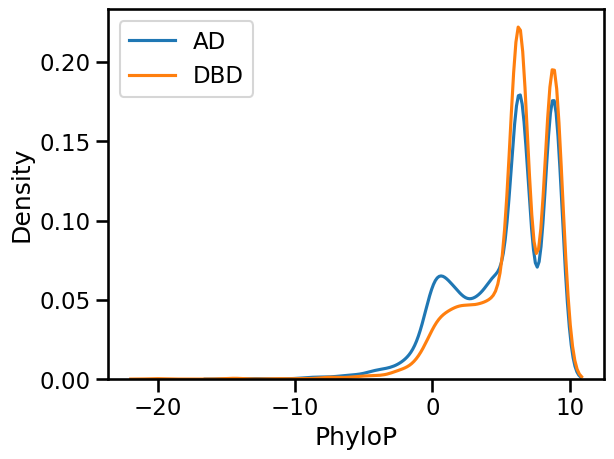

In [65]:
sns.kdeplot(ad_phylo_P["PhyloP"], label = "AD")
sns.kdeplot(dbd_phylo_P["PhyloP"], label = "DBD")
plt.legend()

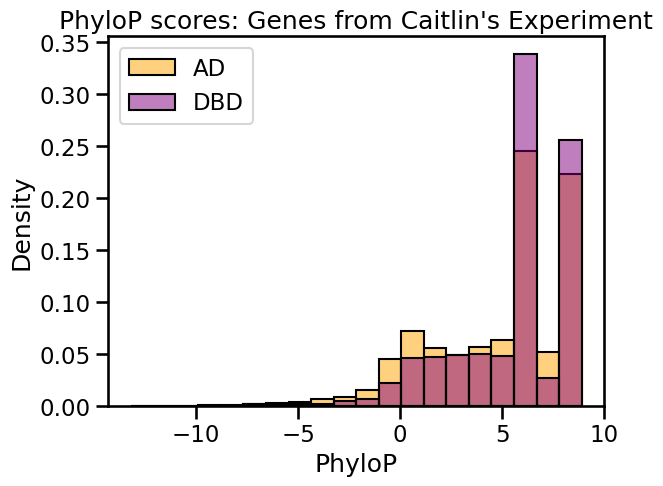

In [66]:
np.arange(-20, 10.1, 0.5)
sns.histplot(ad_phylo_P["PhyloP"], label = "AD", stat = "density", bins = bins, color = "orange", alpha =0.5)
sns.histplot(dbd_phylo_P["PhyloP"], label = "DBD", stat = "density", bins = bins, color = "purple", alpha =0.5)
plt.title("PhyloP scores: Genes from Caitlin's Experiment")
plt.legend();

In [67]:
zoonomia_phyloP["P"] = 10 ** (-1 * np.abs(zoonomia_phyloP["PhyloP"]))
zoonomia_phyloP

chr     start       end  PhyloP             P
0       11  31806401  31806402   6.331  4.666594e-07
1       11  31806402  31806403   8.755  1.757924e-09
2       11  31806403  31806404   6.331  4.666594e-07
3       11  31806404  31806405   6.331  4.666594e-07
4       11  31806405  31806406   5.917  1.210598e-06
...    ...       ...       ...     ...           ...
19438   15  36892454  36892455   7.067  8.570378e-08
19439   15  36892455  36892456   6.311  4.886524e-07
19440   15  36892456  36892457   2.910  1.230269e-03
19441   15  36892457  36892458   6.253  5.584702e-07
19442   15  36892458  36892459   8.126  7.481695e-09

[19443 rows x 5 columns]

In [68]:
print(max(zoonomia_phyloP["P"]))
print(min(zoonomia_phyloP["P"]))

1.0
1e-20


In [69]:
zoonomia_phyloP["q"] = stats.false_discovery_control(zoonomia_phyloP["P"])
bh_sig = zoonomia_phyloP[zoonomia_phyloP["q"] < 0.05]
bh_sig

chr     start       end  PhyloP             P             q
0       11  31806401  31806402   6.331  4.666594e-07  9.588331e-07
1       11  31806402  31806403   8.755  1.757924e-09  7.853911e-09
2       11  31806403  31806404   6.331  4.666594e-07  9.588331e-07
3       11  31806404  31806405   6.331  4.666594e-07  9.588331e-07
4       11  31806405  31806406   5.917  1.210598e-06  2.082426e-06
...    ...       ...       ...     ...           ...           ...
19438   15  36892454  36892455   7.067  8.570378e-08  2.877960e-07
19439   15  36892455  36892456   6.311  4.886524e-07  9.588331e-07
19440   15  36892456  36892457   2.910  1.230269e-03  1.605808e-03
19441   15  36892457  36892458   6.253  5.584702e-07  1.008389e-06
19442   15  36892458  36892459   8.126  7.481695e-09  2.679930e-08

[16874 rows x 6 columns]

In [70]:
bonferroni_sig = zoonomia_phyloP[zoonomia_phyloP["P"] < (.05 / len(zoonomia_phyloP))]
bonferroni_sig

chr     start       end  PhyloP             P             q
0       11  31806401  31806402   6.331  4.666594e-07  9.588331e-07
1       11  31806402  31806403   8.755  1.757924e-09  7.853911e-09
2       11  31806403  31806404   6.331  4.666594e-07  9.588331e-07
3       11  31806404  31806405   6.331  4.666594e-07  9.588331e-07
4       11  31806405  31806406   5.917  1.210598e-06  2.082426e-06
...    ...       ...       ...     ...           ...           ...
19437   15  36892453  36892454   8.763  1.725838e-09  7.853911e-09
19438   15  36892454  36892455   7.067  8.570378e-08  2.877960e-07
19439   15  36892455  36892456   6.311  4.886524e-07  9.588331e-07
19441   15  36892457  36892458   6.253  5.584702e-07  1.008389e-06
19442   15  36892458  36892459   8.126  7.481695e-09  2.679930e-08

[11865 rows x 6 columns]

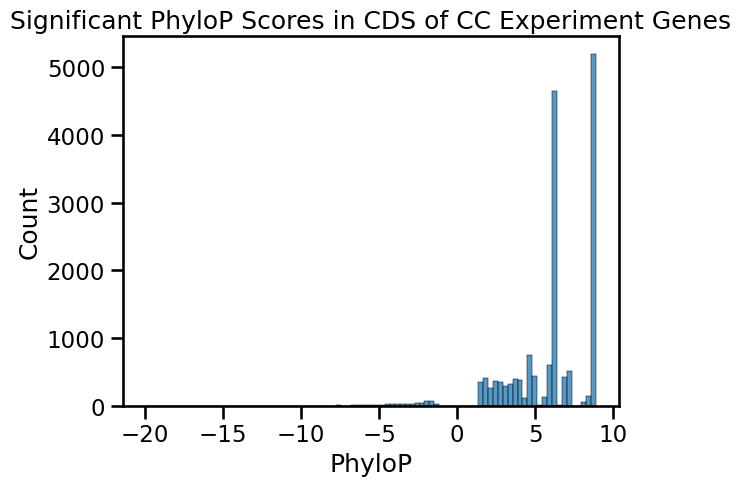

In [71]:
plt.title("Significant PhyloP Scores in CDS of CC Experiment Genes")
sns.histplot(bh_sig["PhyloP"]);

In [72]:
bh_sig.to_csv("../output/zoonomia_phyloP_cc_cds_sig_bh.csv")

In [73]:
bonferroni_sig.to_csv("../output/zoonomia_phyloP_cc_cds_sig_bonferroni.csv")

---
Variance of AD vs DBD PhyloP scores?

In [74]:
AD_variances = []
DBD_variances = []
ENSTs = []

for ENST in set(cc_names["ENST"]):
    ENSTs.append(ENST)
    AD_rows = ad_phylo_P[ad_phylo_P[7] == ENST]["PhyloP"]
    DBD_rows = dbd_phylo_P[dbd_phylo_P[7] == ENST]["PhyloP"]

    AD_variances.append(np.var(AD_rows))
    DBD_variances.append(np.var(DBD_rows))

variance_df = pd.DataFrame({"ENST" : ENSTs, "AD" : AD_variances, "DBD" : DBD_variances})
variance_df

ENST         AD        DBD
0   ENST00000241001  11.364074   5.998196
1   ENST00000339562   3.148861   9.836720
2   ENST00000288319  16.327538  17.143871
3   ENST00000348332  10.571426        NaN
4   ENST00000282549  14.509512  10.675660
5   ENST00000377142   7.969864   9.991970
6   ENST00000265340   7.741581   8.938416
7   ENST00000561208   7.063338   7.108346
8   ENST00000331340  14.698834        NaN
9   ENST00000358127  11.588383   8.336911
10  ENST00000348066  12.641956   8.186125

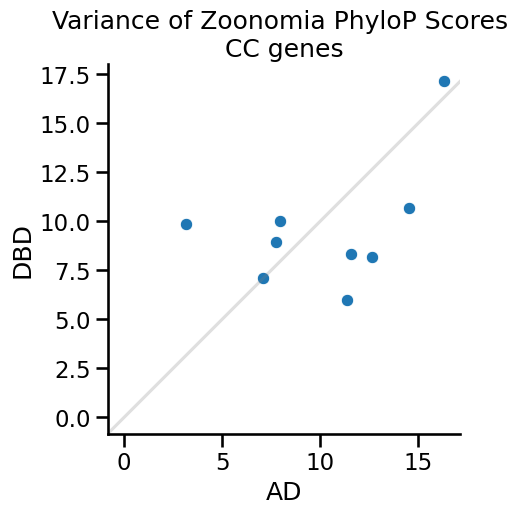

In [75]:
plt.style.use("default")
sns.set_context('talk')
plt.gca().set_aspect('equal', adjustable='box')

plt.axline((0, 0), slope=1, color = "gray", alpha = 0.25)
sns.scatterplot(data = variance_df, x = "AD", y = "DBD")
sns.despine()
plt.title("Variance of Zoonomia PhyloP Scores \nCC genes");

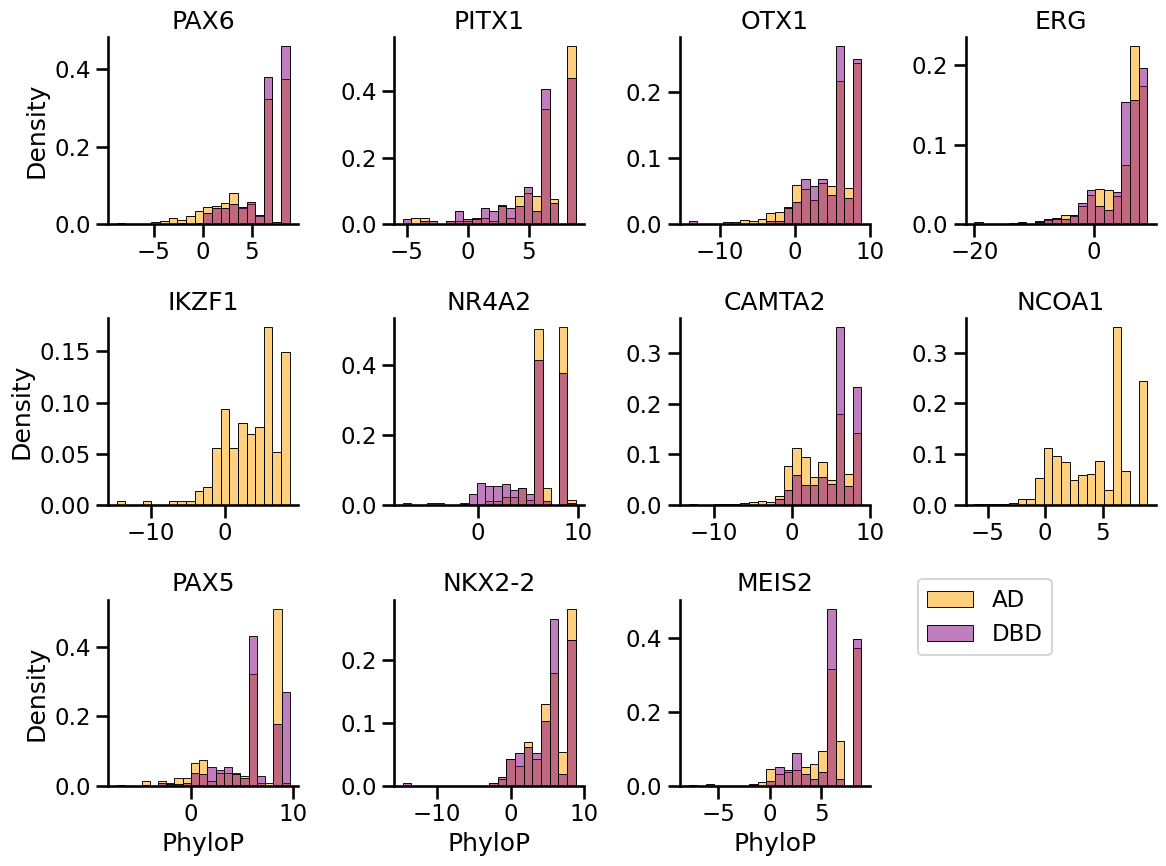

In [77]:
# Create a figure with 3 rows and 4 columns for subplots
fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes

# Initialize variables to store handles and labels for the legend
handles = []
labels = []

# Loop through ENST entries and create histograms
for idx, ENST in enumerate(cc_names.sort_values(by = "ENST")["ENST"].drop_duplicates()):
    if idx >= 11:  # Limit to 11 plots (3 rows * 4 columns, with 1 empty)
        break

    gene = cc_names[cc_names["ENST"] == ENST]["Gene"].iloc[0]
    AD_rows = ad_phylo_P[ad_phylo_P[7] == ENST]["PhyloP"]
    DBD_rows = dbd_phylo_P[dbd_phylo_P[7] == ENST]["PhyloP"]

    if len(AD_rows) > 0 and len(DBD_rows) > 0:
        min_both = min(min(AD_rows), min(DBD_rows))
        max_both = max(max(AD_rows), max(DBD_rows))
        step = (max_both - min_both) / 20
        bins = np.arange(min_both, max_both + step, step)
    else:
        step = (max(AD_rows) - min(AD_rows)) / 20
        bins = np.arange(min(AD_rows), max(AD_rows) + step, step)

    ax = axes[idx]
    ad_plot = sns.histplot(AD_rows, stat="density", bins=bins, color="orange", alpha=0.5, ax=ax, label="AD")
    dbd_plot = sns.histplot(DBD_rows, stat="density", bins=bins, color="purple", alpha=0.5, ax=ax, label="DBD")
    
    sns.despine()

    if idx % 4 == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")

    if idx < 8:
        ax.set_xlabel("")

    ax.set_title(gene)

    # Collect legend handles and labels from the second subplot
    if idx == 1:
        handles, labels = ax.get_legend_handles_labels()

# Create a single legend for the entire figure using the collected handles and labels
fig.legend(handles, labels, bbox_to_anchor = (0, 0, 0.9,0.35))
fig.delaxes(axes[11])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


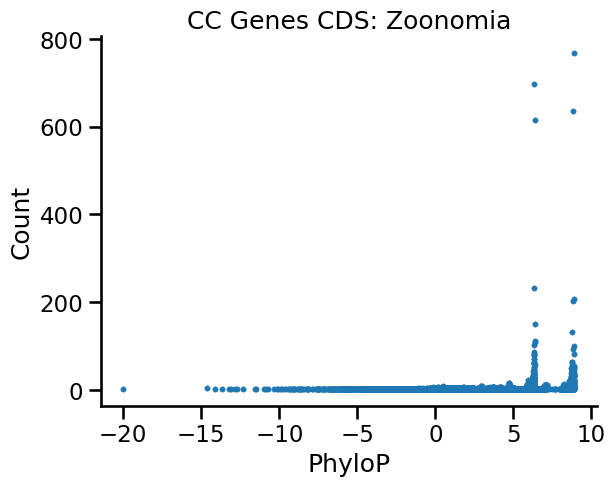

In [108]:
PhyloP_vs_count = pd.DataFrame(cds_phylo_P['PhyloP'].value_counts().reset_index())
sns.scatterplot(data = PhyloP_vs_count, x = "PhyloP", y = "count", edgecolor = None, s = 15)
plt.title("CC Genes CDS: Zoonomia")
plt.ylabel("Count")
sns.despine();

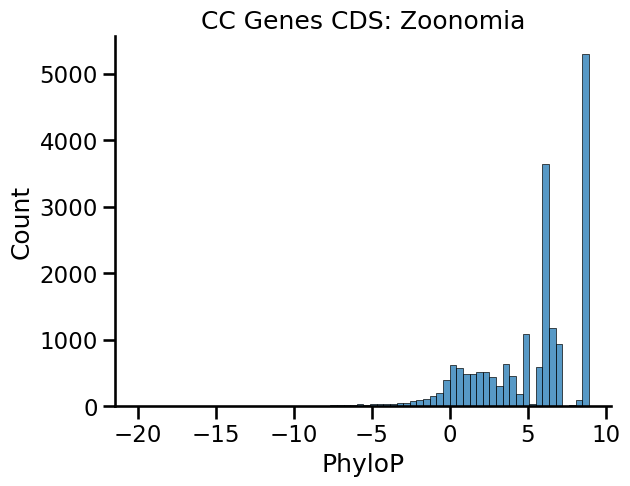

In [112]:
sns.histplot(data = cds_phylo_P, x = "PhyloP")
plt.title("CC Genes CDS: Zoonomia")
plt.ylabel("Count")
sns.despine();